# Config

In [1]:
!pip install pyspark
!pip install pywavelets
! pip install pmdarima
!pip install sktime
# !pip install auto_ts
# !pip install prophet
!pip install -qqq greykite

!pip install ipython-autotime
%load_ext autotime
# %unload_ext autotime

# Install ipython-sql
!pip install ipython-sql
%load_ext sql
# # Execute SQL commands to create a table, insert data, and run a query
# %%sql
# CREATE TABLE test_table(name, age);
# INSERT INTO test_table VALUES('Alice', 24);
# SELECT * FROM test_table;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=fe9aeba100c9346246edfa809b298276e75cb86c8076539c34bfd3dbd2c39450
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 363.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 64.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.7/22.7 MB 21.4 MB/s e

In [2]:
import pyspark
import pyspark.sql as pyspark_sql
import pyspark.sql.types as T
import pyspark.sql.functions  as F
from pyspark.sql.window import Window
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, DataFrame
import pyspark.pandas as ps

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


time: 681 ms (started: 2024-07-27 11:43:01 +00:00)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import os
import warnings
warnings.filterwarnings("ignore")

from dateutil.relativedelta import relativedelta
from scipy.stats import linregress
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from tqdm import tqdm
from datetime import datetime
import math

time: 2.37 s (started: 2024-07-27 11:43:02 +00:00)


In [4]:
# ps.set_option('display.max_columns', None)
# ps.set_option('compute.ops_on_diff_frames', True)
# ps.set_option('display.max_rows', 60)

spark = SparkSession.builder.master("local[*]")\
        .getOrCreate()
        # .config(conf = SparkConf().setAll([("spark.scheduler.mode","FAIR")]))\

# windowSpec  = Window.partitionBy("DEPARTMENT").orderBy("SALARY")
# spark.sparkContext.getConf().getAll()
spark.conf.set(
    "spark.sql.execution.arrow.pyspark.fallback.enabled", "true"
)
spark

time: 27.6 s (started: 2024-07-27 11:43:04 +00:00)


# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 30.7 s (started: 2024-05-07 06:37:12 +00:00)


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Capstone project m5 forecast/preprocess_data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data/")

time: 1min 5s (started: 2024-03-22 13:07:05 +00:00)


In [ ]:
df_product = spark.read.format("csv").options(header = True).load("/content/data/")

time: 44.2 s (started: 2024-03-22 13:08:11 +00:00)


In [ ]:
df_product = df_product.withColumn("SELL", F.col("SELL").cast("float"))\
                       .withColumn("SELL_PRICE", F.col("SELL_PRICE").cast("float"))\
                       .withColumn("DATE", F.to_date(F.col("date")))\
                       .withColumn("DAY_OF_WEEK", F.col("DAY_OF_WEEK").cast("int"))\
                       .withColumn("MONTH", F.col("MONTH").cast("int"))\
                       .withColumn("YEAR", F.col("YEAR").cast("int"))\
                       .withColumn("SNAP_CA", F.col("SNAP_CA").cast("int"))\
                       .withColumn("SNAP_TX", F.col("SNAP_TX").cast("int"))\
                       .withColumn("SNAP_WI", F.col("SNAP_WI").cast("int"))\
                       .drop("DATE_INDEX_ITEM")\
                       .orderBy("ID","ITEM","STORE","DATE")

df_product.printSchema()

root
 |-- ID: string (nullable = true)
 |-- ITEM: string (nullable = true)
 |-- DEPARTMENT: string (nullable = true)
 |-- CATEGORY: string (nullable = true)
 |-- STORE: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- SELL: float (nullable = true)
 |-- SELL_PRICE: float (nullable = true)
 |-- DATE: date (nullable = true)
 |-- WEEK_DAY: string (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- EVENT_NAME_1: string (nullable = true)
 |-- EVENT_TYPE_1: string (nullable = true)
 |-- EVENT_NAME_2: string (nullable = true)
 |-- EVENT_TYPE_2: string (nullable = true)
 |-- SNAP_CA: integer (nullable = true)
 |-- SNAP_TX: integer (nullable = true)
 |-- SNAP_WI: integer (nullable = true)

time: 1.87 s (started: 2024-03-22 13:08:56 +00:00)


In [ ]:
print(df_product.count(), len(df_product.columns))
df_product.show(5, truncate = False)

59181090 20
+---------------------------+-----------+----------+--------+-----+-----+----+----------+----------+---------+-----------+-----+----+------------+------------+------------+------------+-------+-------+-------+
|ID                         |ITEM       |DEPARTMENT|CATEGORY|STORE|STATE|SELL|SELL_PRICE|DATE      |WEEK_DAY |DAY_OF_WEEK|MONTH|YEAR|EVENT_NAME_1|EVENT_TYPE_1|EVENT_NAME_2|EVENT_TYPE_2|SNAP_CA|SNAP_TX|SNAP_WI|
+---------------------------+-----------+----------+--------+-----+-----+----+----------+----------+---------+-----------+-----+----+------------+------------+------------+------------+-------+-------+-------+
|FOODS_1_001_CA_1_evaluation|FOODS_1_001|FOODS_1   |FOODS   |CA_1 |CA   |3.0 |2.0       |2011-01-29|Saturday |1          |1    |2011|NULL        |NULL        |NULL        |NULL        |0      |0      |0      |
|FOODS_1_001_CA_1_evaluation|FOODS_1_001|FOODS_1   |FOODS   |CA_1 |CA   |0.0 |2.0       |2011-01-30|Sunday   |2          |1    |2011|NULL        |NU

# Feature Engineering
Not using feature engineer techniques about scaling, encoding, missing data, outlier yet

Some techniques for generate features by utilize time-series techniques:

- Datetime indicator
- Trendline
- Phasing ratio
- Time-series techniques

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 21.2 s (started: 2024-07-27 11:43:43 +00:00)


In [ ]:
# df_total_result_model.to_csv("/content/drive/MyDrive/Capstone project m5 forecast/df_total_result_model.csv", index = False)

time: 337 µs (started: 2024-05-16 04:23:02 +00:00)


In [7]:
# df_total_result_model = df_sample[["ID","DATE","SELL"]]

df_total_result_model = pd.read_csv("/content/drive/MyDrive/Capstone project m5 forecast/df_total_result_model.csv")
df_total_result_model["DATE"] = pd.to_datetime(df_total_result_model["DATE"], format = "%Y-%m-%d")
print(df_total_result_model.shape)
df_total_result_model.head(2)

(1941000, 12)


ID       DATE  SELL  ARIMA  ERROR_ARIMA  SARIMA  \
0  FOODS_1_004_CA_1_evaluation 2011-01-29   0.0    0.0          NaN     0.0   
1  FOODS_1_004_CA_1_evaluation 2011-01-30   0.0    0.0          NaN     0.0   

   ERROR_SARIMA  ETS  ERROR_ETS  ERROR_PROPHET  PROPHET  ML_LGBM  
0           NaN  0.0        NaN            NaN      0.0      0.0  
1           NaN  0.0        NaN            NaN      0.0      0.0

time: 3.65 s (started: 2024-07-27 11:44:20 +00:00)


In [ ]:
df_sample = pd.read_csv("/content/drive/MyDrive/Capstone project m5 forecast/top1000_product_sample.csv")
df_sample["DATE"] = pd.to_datetime(df_sample["DATE"])
print(df_sample["DATE"].min(), df_sample["DATE"].max())
df_sample.head()

2011-01-29 00:00:00 2016-05-22 00:00:00


ID         ITEM DEPARTMENT CATEGORY STORE STATE  \
0  FOODS_1_004_CA_1_evaluation  FOODS_1_004    FOODS_1    FOODS  CA_1    CA   
1  FOODS_1_004_CA_1_evaluation  FOODS_1_004    FOODS_1    FOODS  CA_1    CA   
2  FOODS_1_004_CA_1_evaluation  FOODS_1_004    FOODS_1    FOODS  CA_1    CA   
3  FOODS_1_004_CA_1_evaluation  FOODS_1_004    FOODS_1    FOODS  CA_1    CA   
4  FOODS_1_004_CA_1_evaluation  FOODS_1_004    FOODS_1    FOODS  CA_1    CA   

   SELL  SELL_PRICE  DATE_INDEX_ITEM       DATE  ... DAY_OF_WEEK  MONTH  YEAR  \
0   0.0         NaN              NaN 2011-01-29  ...           1      1  2011   
1   0.0         NaN              NaN 2011-01-30  ...           2      1  2011   
2   0.0         NaN              NaN 2011-01-31  ...           3      1  2011   
3   0.0         NaN              NaN 2011-02-01  ...           4      2  2011   
4   0.0         NaN              NaN 2011-02-02  ...           5      2  2011   

   EVENT_NAME_1 EVENT_TYPE_1 EVENT_NAME_2 EVENT_TYPE_2 SNAP_CA  SNAP_TX  \
0           NaN          NaN          NaN          NaN       0        0   
1           NaN          NaN          NaN          NaN       0        0   
2           NaN          NaN          NaN          NaN       0        0   
3           NaN          NaN          NaN          NaN       1        1   
4           NaN          NaN          NaN          NaN       1        0   

   SNAP_WI  
0        0  
1        0  
2        0  
3        0  
4        1  

[5 rows x 21 columns]

time: 19.7 s (started: 2024-06-24 14:14:05 +00:00)


In [ ]:
def plot_timeseries_by_level(
    df: pd.DataFrame,
    key_level = ["ID"],
    target_var = "SELL",
    start_date = "2011-01-01",
    end_date = "2016-05-22",
    hover_mode = "x unified",
    agg_function = "mean",
):
    fig = go.Figure(data= [])

    for key, df_group in df.groupby(key_level):
        df_group = df_group[
            df_group["DATE"].between(start_date, end_date)
        ]
        df_group = df_group.groupby([*key_level,"DATE"]).agg({target_var : agg_function}).reset_index()

        fig.add_trace(
            go.Scatter(
                x = df_group["DATE"],
                y = df_group[target_var],
                name = str(key),
                connectgaps = False,
                mode = "lines",
            )
        )
    # remove square bracket in title
    title_key_level = str(key_level)
    for reg in ["'","[","]"]:
        title_key_level = str(title_key_level).replace(reg, " ")

    fig.update_layout(
        title =target_var + " data of each" + title_key_level + "from " + start_date + " to " + end_date,
        hovermode= hover_mode
    )
    fig.show()

time: 1.55 ms (started: 2024-06-24 14:14:28 +00:00)


## Datetime indicator

In [ ]:
def week_of_month(dt):
    """
        start_date_index present first index following week day
        1 : Sunday,
        2 : Saturday and so on
        Returns the week of the month for the specified date.
    """
    start_date_index = 2
    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + (start_date_index + first_day.weekday()) % 7

    return int(math.ceil(adjusted_dom/7))

time: 936 µs (started: 2024-06-24 14:14:44 +00:00)


In [ ]:
df_sample["YEARWEEK"] = df_sample["DATE"].dt.isocalendar()["year"]*100 + df_sample["DATE"].dt.isocalendar()["week"]
df_sample["QUARTER"] = df_sample["DATE"].dt.quarter

df_sample["DAY_OF_MONTH"] = df_sample["DATE"].dt.day
df_sample["DAY_OF_QUARTER"] = (df_sample["DATE"] - pd.PeriodIndex(df_sample["DATE"],freq='Q').start_time).dt.days + 1
df_sample["DAY_OF_YEAR"] = df_sample["DATE"].dt.day_of_year
df_sample["DAY_OF_WEEK"] = df_sample["DATE"].dt.dayofweek
df_sample["IS_WEEKEND"] = df_sample["DAY_OF_WEEK"] > 4 # Saturday and Sunday

df_sample["WEEK_OF_MONTH"] = df_sample["YEARWEEK"].apply(lambda x: (x%100 - 1)% 4 + 1)
# df_sample["WEEK_OF_MONTH"] = df_sample["DATE"].apply(week_of_month)
df_sample["WEEK_OF_QUARTER"] = df_sample["YEARWEEK"].apply(lambda x: (x%100 - 1)% 13 + 1)

df_sample["IS_MONTH_START"] = np.where(df_sample["DATE"].dt.is_month_start == True, 1, 0)
df_sample["IS_MONTH_END"] = np.where(df_sample["DATE"].dt.is_month_end == True, 1, 0)
df_sample["IS_QUARTER_START"] = np.where(df_sample["DATE"].dt.is_quarter_start == True, 1, 0)
df_sample["IS_QUARTER_END"] = np.where(df_sample["DATE"].dt.is_quarter_end == True, 1, 0)
df_sample["IS_YEAR_START"] = np.where(df_sample["DATE"].dt.is_year_end == True, 1, 0)
df_sample["IS_YEAR_END"] = np.where(df_sample["DATE"].dt.is_year_end == True, 1, 0)

time: 6.65 s (started: 2024-06-24 14:14:45 +00:00)


In [ ]:
df_sample.describe()

SELL    SELL_PRICE  DATE_INDEX_ITEM   DAY_OF_WEEK  \
count  1.941000e+06  1.822028e+06              0.0  1.941000e+06   
mean   1.139443e+01  1.781088e+00              NaN  3.002576e+00   
std    1.553195e+01  1.492377e+00              NaN  2.000643e+00   
min    0.000000e+00  5.000000e-02              NaN  0.000000e+00   
25%    2.000000e+00  9.700000e-01              NaN  1.000000e+00   
50%    8.000000e+00  1.380000e+00              NaN  3.000000e+00   
75%    1.500000e+01  2.000000e+00              NaN  5.000000e+00   
max    7.630000e+02  2.398000e+01              NaN  6.000000e+00   

              MONTH          YEAR       SNAP_CA       SNAP_TX       SNAP_WI  \
count  1.941000e+06  1.941000e+06  1.941000e+06  1.941000e+06  1.941000e+06   
mean   6.334879e+00  2.013249e+03  3.297269e-01  3.297269e-01  3.297269e-01   
std    3.439200e+00  1.556975e+00  4.701140e-01  4.701140e-01  4.701140e-01   
min    1.000000e+00  2.011000e+03  0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.000000e+00  2.012000e+03  0.000000e+00  0.000000e+00  0.000000e+00   
50%    6.000000e+00  2.013000e+03  0.000000e+00  0.000000e+00  0.000000e+00   
75%    9.000000e+00  2.015000e+03  1.000000e+00  1.000000e+00  1.000000e+00   
max    1.200000e+01  2.016000e+03  1.000000e+00  1.000000e+00  1.000000e+00   

            YEARWEEK  ...  DAY_OF_QUARTER   DAY_OF_YEAR  WEEK_OF_MONTH  \
count      1941000.0  ...    1.941000e+06  1.941000e+06   1.941000e+06   
mean   201350.803194  ...    4.607625e+01  1.773472e+02   2.496136e+00   
std       153.967279  ...    2.621116e+01  1.051027e+02   1.120099e+00   
min         201104.0  ...    1.000000e+00  1.000000e+00   1.000000e+00   
25%         201222.0  ...    2.400000e+01  8.600000e+01   1.000000e+00   
50%         201339.0  ...    4.600000e+01  1.720000e+02   2.000000e+00   
75%         201504.0  ...    6.900000e+01  2.690000e+02   3.000000e+00   
max         201620.0  ...    9.200000e+01  3.660000e+02   4.000000e+00   

       WEEK_OF_QUARTER  IS_MONTH_START  IS_MONTH_END  IS_QUARTER_START  \
count     1.941000e+06    1.941000e+06  1.941000e+06      1.941000e+06   
mean      6.964451e+00    3.297269e-02  3.297269e-02      1.081917e-02   
std       3.733563e+00    1.785651e-01  1.785651e-01      1.034510e-01   
min       1.000000e+00    0.000000e+00  0.000000e+00      0.000000e+00   
25%       4.000000e+00    0.000000e+00  0.000000e+00      0.000000e+00   
50%       7.000000e+00    0.000000e+00  0.000000e+00      0.000000e+00   
75%       1.000000e+01    0.000000e+00  0.000000e+00      0.000000e+00   
max       1.300000e+01    1.000000e+00  1.000000e+00      1.000000e+00   

       IS_QUARTER_END  IS_YEAR_START   IS_YEAR_END  
count    1.941000e+06   1.941000e+06  1.941000e+06  
mean     1.081917e-02   2.575992e-03  2.575992e-03  
std      1.034510e-01   5.068883e-02  5.068883e-02  
min      0.000000e+00   0.000000e+00  0.000000e+00  
25%      0.000000e+00   0.000000e+00  0.000000e+00  
50%      0.000000e+00   0.000000e+00  0.000000e+00  
75%      0.000000e+00   0.000000e+00  0.000000e+00  
max      1.000000e+00   1.000000e+00  1.000000e+00  

[8 rows x 22 columns]

time: 4.02 s (started: 2024-06-24 14:14:51 +00:00)


## Holiday calendar

In [ ]:
import holidays

# Define a function to check if any day within the week preceding the week_ending_date is a holiday
def is_holiday_in_week(country_cd, week_ending_date):
    # Initialize the holidays package for the specified country
    country_holidays = holidays.CountryHoliday(country_cd)

    # Get the start and end of the week
    start_of_week = week_ending_date - timedelta(days=week_ending_date.weekday()) # Get the start of the week (Monday)

    # Check if any day within the week is a holiday
    for single_date in [start_of_week + timedelta(days=n) for n in range(7)]:
        if single_date in country_holidays:
            return 1
    return 0

# Define the user-defined function (UDF)
is_holiday_in_week_udf = udf(is_holiday_in_week, IntegerType())

# Add holiday_flag feature
agg_df = agg_df.withColumn("holiday_flag", is_holiday_in_week_udf(col("country_cd"), col("week_ending_date")))

display(agg_df.select('Country','week_ending_date','year','month','week_number','holiday_flag'))

time: 90.3 ms (started: 2024-05-07 06:41:02 +00:00)


## Time-series techniques

### AR and MA

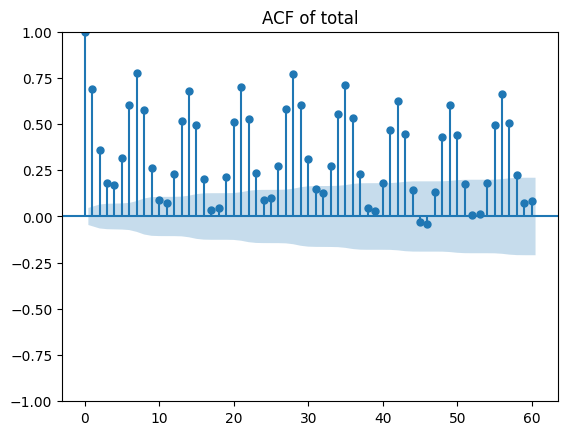

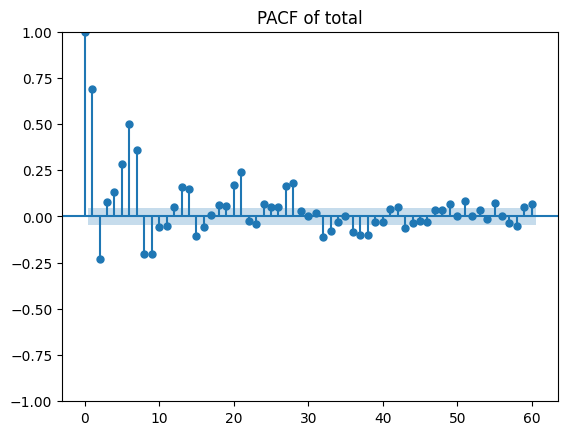

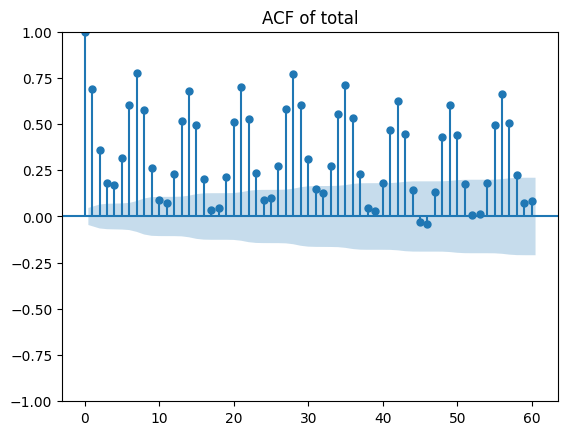

time: 4.17 s (started: 2024-06-24 14:14:55 +00:00)


In [ ]:
df_agg_acf = df_sample[(df_sample["DATE"].between("2011-01-29", "2015-12-31"))].groupby(["DATE"])["SELL"].sum().reset_index()

plot_pacf(df_agg_acf["SELL"], lags = 60, title = "PACF of total")
plot_acf(df_agg_acf["SELL"], lags = 60, title = "ACF of total")

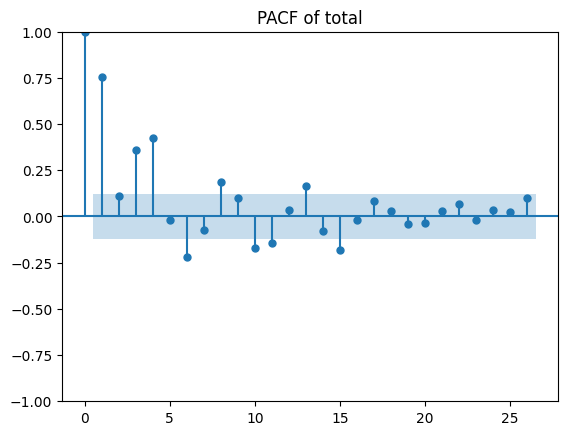

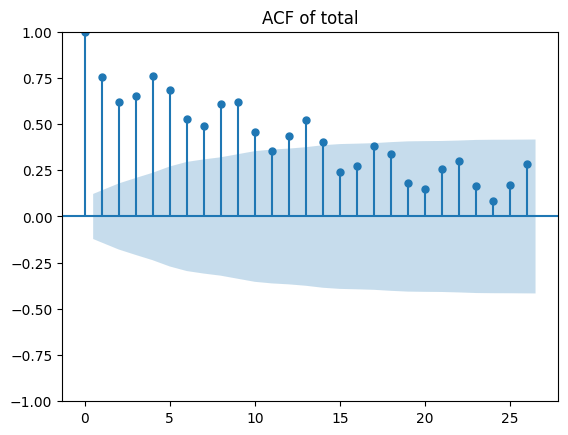

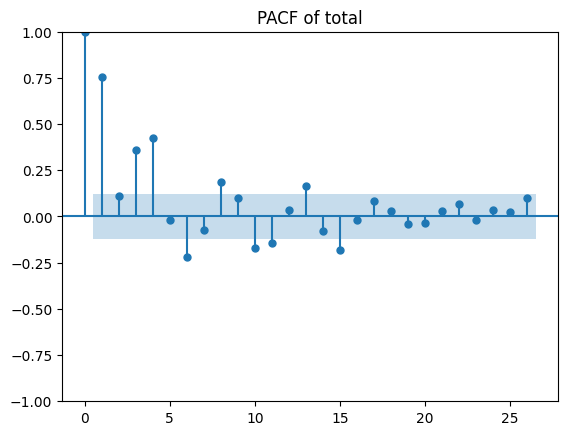

time: 2.82 s (started: 2024-06-24 14:15:00 +00:00)


In [ ]:
df_agg_acf = df_sample[(df_sample["DATE"].between("2011-01-29", "2015-12-31"))].groupby(["YEARWEEK"])["SELL"].sum().reset_index()

plot_acf(df_agg_acf["SELL"], lags = 26, title = "ACF of total")
plot_pacf(df_agg_acf["SELL"], lags = 26, title = "PACF of total")

In [ ]:
df_ts_feature_total = df_sample[["ID","DATE","SELL"]].copy()

df_explode_date = pd.DataFrame(
    data={
        "ID": df_sample["ID"].unique(),
        "DATE_RANGE": [
            pd.date_range(
                start=df_sample[df_sample["ID"] == item_id]["DATE"].min(),
                end=df_sample[df_sample["ID"] == item_id]["DATE"].max(),
                freq="W-MON",
            )
            for item_id in df_sample["ID"].unique()
        ],
    }
)
df_explode_date = df_explode_date.explode("DATE_RANGE")
df_explode_date.columns = ["ID","DATE"]

time: 6min 8s (started: 2024-06-24 14:15:02 +00:00)


In [ ]:
df_ts_feature_total = df_ts_feature_total.merge(df_explode_date, on =["ID", "DATE"], how = "right")
df_ts_feature_total = df_ts_feature_total.fillna(0)

time: 583 ms (started: 2024-06-24 14:21:10 +00:00)


In [ ]:
# Lag
threshold_yw_cutoff = 143

for lag_number in [
    threshold_yw_cutoff,
    threshold_yw_cutoff + 1,
    threshold_yw_cutoff + 2,
    threshold_yw_cutoff + 7,
    threshold_yw_cutoff + 8,
    threshold_yw_cutoff + 14,
    threshold_yw_cutoff + 15,
    threshold_yw_cutoff + 30,
    threshold_yw_cutoff + 31,
]:
    df_ts_feature_total[f"total_lag_{lag_number}"] = df_ts_feature_total.groupby(["ID"])[
        "SELL"
    ].shift(lag_number)

time: 269 ms (started: 2024-06-24 14:21:11 +00:00)


In [ ]:
# lag then moving
# Moving avg, median, min, max
for lag_number in [threshold_yw_cutoff, threshold_yw_cutoff + 7]:
    for moving_number in [7, 14, 30, 60, 90]:
        df_ts_feature_total[
            f"total_lag_{lag_number}_moving_mean_{moving_number}"
        ] = df_ts_feature_total.groupby(["ID"])[
            "SELL"
        ].apply(
            lambda x: x.shift(lag_number).rolling(window=moving_number).mean()
        )
        df_ts_feature_total[
            f"total_lag_{lag_number}_moving_std_{moving_number}"
        ] = df_ts_feature_total.groupby(["ID"])[
            "SELL"
        ].apply(
            lambda x: x.shift(lag_number).rolling(window=moving_number).std()
        )
        df_ts_feature_total[
            f"total_lag_{lag_number}_moving_median_{moving_number}"
        ] = df_ts_feature_total.groupby(["ID"])[
            "SELL"
        ].apply(
            lambda x: x.shift(lag_number).rolling(window=moving_number).median()
        )
        df_ts_feature_total[
            f"total_lag_{lag_number}_moving_min_{moving_number}"
        ] = df_ts_feature_total.groupby(["ID"])[
            "SELL"
        ].apply(
            lambda x: x.shift(lag_number).rolling(window=moving_number).min()
        )
        df_ts_feature_total[
            f"total_lag_{lag_number}_moving_max_{moving_number}"
        ] = df_ts_feature_total.groupby(["ID"])[
            "SELL"
        ].apply(
            lambda x: x.shift(lag_number).rolling(window=moving_number).max()
        )

time: 23.9 s (started: 2024-06-24 14:21:11 +00:00)


In [ ]:
df_ts_feature_total = df_ts_feature_total.fillna(0)
print(df_ts_feature_total.shape)
df_ts_feature_total.head(3)

(277000, 62)


ID       DATE  SELL  total_lag_143  total_lag_144  \
0  FOODS_1_004_CA_1_evaluation 2011-01-31   0.0            0.0            0.0   
1  FOODS_1_004_CA_1_evaluation 2011-02-07   0.0            0.0            0.0   
2  FOODS_1_004_CA_1_evaluation 2011-02-14   0.0            0.0            0.0   

   total_lag_145  total_lag_150  total_lag_151  total_lag_157  total_lag_158  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   

   ...  total_lag_150_moving_mean_60  total_lag_150_moving_std_60  \
0  ...                           0.0                          0.0   
1  ...                           0.0                          0.0   
2  ...                           0.0                          0.0   

   total_lag_150_moving_median_60  total_lag_150_moving_min_60  \
0                             0.0                          0.0   
1                             0.0                          0.0   
2                             0.0                          0.0   

   total_lag_150_moving_max_60  total_lag_150_moving_mean_90  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          0.0                           0.0   

   total_lag_150_moving_std_90  total_lag_150_moving_median_90  \
0                          0.0                             0.0   
1                          0.0                             0.0   
2                          0.0                             0.0   

   total_lag_150_moving_min_90  total_lag_150_moving_max_90  
0                          0.0                          0.0  
1                          0.0                          0.0  
2                          0.0                          0.0  

[3 rows x 62 columns]

time: 453 ms (started: 2024-06-24 14:21:35 +00:00)


### Denoise wavelet

Wavelet denoising (usually used with electric signals) is a way to remove the unnecessary noise from a time series. This method calculates coefficients called the "wavelet coefficients". These coefficients decide which pieces of information to keep (signal) and which ones to discard (noise).

We make use of the MAD (mean absolute deviation) value to understand the randomness in the sales and accordingly decide the minimum threshold for the wavelet coefficients in the time series. We filter out the low coefficients from the wavelets and reconstruct the sales data from the remaining coefficients and that's it; we have successfully removed noise from the sales data.

In [ ]:
import pywt

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

time: 58.5 ms (started: 2024-05-14 07:17:58 +00:00)


In [ ]:
df_ts_feature_total["SELL_WAVELET"] = denoise_signal(df_ts_feature_total["SELL"])

temp_plot = df_ts_feature_total.groupby(["DATE"]).agg(
    {
        "SELL": "mean",
        "SELL_WAVELET": "mean",
    }
).reset_index()

fig = go.Figure(
    data = [
        go.Scatter(x = temp_plot["DATE"], y = temp_plot["SELL"], name = "Origin"),
        go.Scatter(x = temp_plot["DATE"], y = temp_plot["SELL_WAVELET"], name = "Wavelet")
    ]
)
fig.show()

time: 348 ms (started: 2024-05-14 07:17:58 +00:00)


## Trendline

Utilze the idea of trend change point to create function apply linear regression to calculate trend in diverse period (yearly, quarterly, monthly)

In [ ]:
def calculate_future_trendline(df, target_var, date_cutoff = "2015-12-31"):
    warnings.filterwarnings("ignore")
    df_result = pd.DataFrame(columns = ["ID","DATE", "TRENDLINE_DAILY"])

    for _, df_group in tqdm(df.groupby(["ID"])):
        df_group = df_group[["ID","DATE","DAY_OF_YEAR", target_var]].sort_values("DATE").reset_index(drop = True)

        # df_group["DATE"] = pd.to_datetime(
        #     df_group["YEARWEEK"].astype(str) + "-1", format="%G%V-%w"
        # )
        # df_group["YEAR"] = df_group["DATE"].dt.isocalendar().year
        # df_group["MONTH"] = df_group["DATE"].dt.month
        # df_group["WEEK"] = df_group["DATE"].dt.isocalendar().week

        # df_group["COUNT WEEKS"] = (
        #     df_group.groupby(["YEAR", "MONTH"])["WEEK"].transform("count").astype(int)
        # )
        # df_group["WEEK ORDER"] = (
        #     df_group.groupby(["YEAR", "MONTH"])["WEEK"].transform("rank").astype(int)
        # )

        # df_group["YEARWEEK_ORDER"] = df_group["YEARWEEK"].transform("rank").astype("int")
        df_group["TRENDLINE_DAILY"] = 0

        df_history = df_group[df_group["DATE"] <= date_cutoff]
        df_future = df_group[df_group["DATE"] > date_cutoff]
        try:
            fulltime_slope, fulltime_intercept, r_value, p_value, std_err = linregress(
                x=df_history["DAY_OF_YEAR"].values, y=df_history["SELL"].values
            )

            last_26weeks_slope, last_26weeks_intercept, r_value, p_value, std_err = linregress(
                x=df_history["DAY_OF_YEAR"][-365:].values, y=df_history["SELL"][-365:].values
            )

            weighted_arr = [1, 0.5]
            intercept_arr = [fulltime_intercept, last_26weeks_intercept]
            slope_arr = [fulltime_slope, last_26weeks_slope]

            forecast_intercept = sum(
                [intercept_arr[idx] * weight for idx, weight in enumerate(weighted_arr)]
            ) / sum(weighted_arr)
            forecast_slope = sum(
                [slope_arr[idx] * weight for idx, weight in enumerate(weighted_arr)]
            ) / sum(weighted_arr)

            df_future["TRENDLINE_DAILY"] = (
                forecast_intercept + forecast_slope * df_future["DAY_OF_YEAR"]
            )
            df_history["TRENDLINE_DAILY"] = fulltime_intercept + fulltime_slope * df_history["DAY_OF_YEAR"]
        except:
            pass

        df_temp = df_future.append(df_history)
        df_temp = df_temp[["ID","DATE", "TRENDLINE_DAILY"]]
        df_result = pd.concat([df_result, df_temp])

    return df_result

time: 5.32 ms (started: 2024-06-24 14:21:36 +00:00)


In [ ]:
df_trendline_feature = calculate_future_trendline(df_sample[df_sample["DATE"] >= "2011-01-01"], target_var = "SELL")
df_trendline_feature.describe()

100%|██████████| 1000/1000 [00:24<00:00, 40.20it/s]


TRENDLINE_DAILY
count     1.941000e+06
mean      1.139862e+01
std       9.661372e+00
min       1.638215e+00
25%       6.727284e+00
50%       8.369425e+00
75%       1.235631e+01
max       1.603319e+02

time: 26.2 s (started: 2024-06-24 14:21:36 +00:00)


In [ ]:
df_trendline_feature.head(3)

ID       DATE  TRENDLINE_DAILY
1798  FOODS_1_004_CA_1_evaluation 2016-01-01        13.491077
1799  FOODS_1_004_CA_1_evaluation 2016-01-02        13.470482
1800  FOODS_1_004_CA_1_evaluation 2016-01-03        13.449886

time: 18.1 ms (started: 2024-06-24 14:22:02 +00:00)


In [ ]:
df_temp = df_sample.merge(df_trendline_feature, on = ["ID","DATE"], how = "left")
df_temp.shape

(1941000, 36)

time: 2.35 s (started: 2024-06-24 14:22:02 +00:00)


In [ ]:
temp_plot = df_temp[df_temp["ID"] == "FOODS_1_218_TX_2_evaluation"]
fig = go.Figure(
    data = [
        go.Scatter(x = temp_plot["DATE"], y = temp_plot["SELL"]),
        go.Scatter(x = temp_plot["DATE"], y = temp_plot["TRENDLINE_DAILY"])
    ]
)
fig.show()

time: 2.28 s (started: 2024-06-24 14:22:04 +00:00)


## Phasing ratio (seasonal index)

Utilze the idea of seasonality change point to create function calculating ratio contribution of index datetime(daily) in a season(weekly) and can be tuning in diverse frequency/period (daily/weekly, daily/monthly, daily/quarterly, weekly/monthly, ...)

In [ ]:
def create_features_phasing_ratio(df, target_var):
    ratio_WEEK_MONTH_arr = []

    for key, df_group in tqdm(
        df.groupby(["ID"])
    ):
        df_group = df_group.sort_values("DATE").reset_index(drop = True)
        df_group[target_var] = df_group[target_var].fillna(0)

        df_group["DAY_WEEK_RATIO"] = df_group["SELL"] / df_group.groupby(
            ["YEARWEEK"]
        )["SELL"].transform("sum")

        df_group["DAY_WEEK_COUNT"] = df_group.groupby(["YEARWEEK"])[
            "DATE"
        ].transform("count")

        df_group["DAY_WEEK_ORDER"] = df_group.groupby(["YEARWEEK"])[
            "DATE"
        ].transform("rank")

        ratio_WEEK_MONTH = (
            df_group.groupby(["DAY_WEEK_COUNT","DAY_WEEK_ORDER"])
            .agg({"DAY_WEEK_RATIO": ["mean", "median", "std"]})
            .reset_index()
        )

        ratio_WEEK_MONTH.columns = ["_".join(col) for col in ratio_WEEK_MONTH.columns]
        ratio_WEEK_MONTH["KEY"] = key
        ratio_WEEK_MONTH_arr.append(ratio_WEEK_MONTH)

    # ********************************************************
    df_ratio_WEEK_MONTH = pd.concat(ratio_WEEK_MONTH_arr)
    df_ratio_WEEK_MONTH = df_ratio_WEEK_MONTH.query("`DAY_WEEK_COUNT_` >= 7")
    df_ratio_WEEK_MONTH = df_ratio_WEEK_MONTH.dropna(
        subset=["DAY_WEEK_RATIO_median"]
    )
    df_ratio_WEEK_MONTH["DAY_WEEK_ORDER_"] = df_ratio_WEEK_MONTH[
        "DAY_WEEK_ORDER_"
    ].astype(int)
    df_ratio_WEEK_MONTH["DAY_WEEK_COUNT_"] = df_ratio_WEEK_MONTH["DAY_WEEK_COUNT_"].astype(int)

    df_ratio_WEEK_MONTH.columns = [
        "DAY_WEEK_COUNT",
        "DAY_WEEK_ORDER",
        "RATIO_MEAN",
        "RATIO_MEDIAN",
        "RATIO_STD",
        "KEY",
    ]

    return df_ratio_WEEK_MONTH

time: 1.62 ms (started: 2024-06-24 14:22:07 +00:00)


In [ ]:
df_phasing_features = df_sample[["ID","DATE","YEARWEEK","SELL"]].copy()

df_phasing_features["KEY"] = df_phasing_features["ID"]

df_phasing_features["DAY_WEEK_COUNT"] = (
    df_phasing_features.groupby(["KEY","YEARWEEK"])["DATE"]
    .transform("count")
    .astype(int)
)
df_phasing_features["DAY_WEEK_ORDER"] = (
    df_phasing_features.groupby(["KEY","YEARWEEK"])["DATE"]
    .transform("rank")
    .astype(int)
)

df_phasing_features = df_phasing_features.sort_values(["KEY", "DATE"]).reset_index(
    drop=True
)

df_phasing_features["FUTURE"] = np.where(df_phasing_features["DATE"] < "2016-01-01", "N", "Y")

df_ratio_WEEK_MONTH = create_features_phasing_ratio(df_phasing_features.query("FUTURE == 'N'"), "SELL")
df_ratio_WEEK_MONTH = df_ratio_WEEK_MONTH.fillna(0).reset_index(drop = True)

100%|██████████| 1000/1000 [00:12<00:00, 78.17it/s]


time: 15.2 s (started: 2024-06-24 14:22:07 +00:00)


In [ ]:
df_ratio_WEEK_MONTH.head(10)

DAY_WEEK_COUNT  DAY_WEEK_ORDER  RATIO_MEAN  RATIO_MEDIAN  RATIO_STD  \
0               7               1    0.116853      0.111111   0.076612   
1               7               2    0.119435      0.111111   0.082605   
2               7               3    0.128682      0.125000   0.072536   
3               7               4    0.126809      0.120690   0.091161   
4               7               5    0.147803      0.153846   0.067811   
5               7               6    0.178910      0.181818   0.083930   
6               7               7    0.181508      0.157895   0.167845   
7               7               1    0.138476      0.129870   0.094795   
8               7               2    0.138847      0.129032   0.096078   
9               7               3    0.131121      0.125984   0.070998   

                           KEY  
0  FOODS_1_004_CA_1_evaluation  
1  FOODS_1_004_CA_1_evaluation  
2  FOODS_1_004_CA_1_evaluation  
3  FOODS_1_004_CA_1_evaluation  
4  FOODS_1_004_CA_1_evaluation  
5  FOODS_1_004_CA_1_evaluation  
6  FOODS_1_004_CA_1_evaluation  
7  FOODS_1_004_CA_3_evaluation  
8  FOODS_1_004_CA_3_evaluation  
9  FOODS_1_004_CA_3_evaluation

time: 37.6 ms (started: 2024-06-24 14:22:22 +00:00)


In [ ]:
df_ratio_WEEK_MONTH = df_ratio_WEEK_MONTH.rename(columns = {"KEY" : "ID"})
df_phasing_features = df_phasing_features.merge(df_ratio_WEEK_MONTH, on = ["DAY_WEEK_COUNT","DAY_WEEK_ORDER","ID"], how = "left")
df_phasing_features = df_phasing_features.rename(columns = {"DAY_WEEK_ORDER" : "DAY_OF_WEEK"}).drop(["KEY","FUTURE"], axis = 1)
print(df_phasing_features.shape)
df_phasing_features.head(3)

(1941000, 9)


ID       DATE  YEARWEEK  SELL  DAY_WEEK_COUNT  \
0  FOODS_1_004_CA_1_evaluation 2011-01-29    201104   0.0               2   
1  FOODS_1_004_CA_1_evaluation 2011-01-30    201104   0.0               2   
2  FOODS_1_004_CA_1_evaluation 2011-01-31    201105   0.0               7   

   DAY_OF_WEEK  RATIO_MEAN  RATIO_MEDIAN  RATIO_STD  
0            1         NaN           NaN        NaN  
1            2         NaN           NaN        NaN  
2            1    0.116853      0.111111   0.076612

time: 886 ms (started: 2024-06-24 14:22:22 +00:00)


## Change point

https://freedium.cfd/https://medium.com/dataman-in-ai/change-point-detection-in-time-series-c0b507752889

In [ ]:
!pip install ruptures
!pip install changefinder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 1.5 MB/s eta 0:00:00
  Created wheel for changefinder: filename=changefinder-0.3-py3-none-any.whl size=3824 sha256=df7bb9680d3ba9cac3cef84e12b9310b67b69069999caedec4867c8a64841c51
  Stored in directory: /root/.cache/pip/wheels/f2/fa/e8/f408bd08e5ec7efe062c717bc3997bde871f42a2dc1e133b2b
Successfully built changefinder
time: 48.8 s (started: 2024-05-14 07:31:17 +00:00)


In [ ]:
import ruptures as rpt
import changefinder

def findChangePoints(ts, r, order, smooth):
    '''
       r: Discounting rate
       order: AR model order
       smooth: smoothing window size T
    '''
    cf = changefinder.ChangeFinder(r=r, order=order, smooth=smooth)
    ts_score = [cf.update(p) for p in ts]
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    plt.figure(figsize=(16,4))
    plt.plot(ts_score, color='red')
    return(ts_score)

# Point the change points:
def plot_change_points(ts,ts_change_loc):
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')

time: 1.3 s (started: 2024-05-14 07:32:17 +00:00)


In [ ]:
temp_plot = df_temp[df_temp["ID"] == "FOODS_1_218_TX_2_evaluation"]
# fig = go.Figure(
#     data = [
#         go.Scatter(x = temp_plot["DATE"], y = temp_plot["SELL"]),
#         go.Scatter(x = temp_plot["DATE"], y = temp_plot["TRENDLINE_DAILY"])
#     ]
# )
# fig.show()

time: 413 ms (started: 2024-05-14 07:32:25 +00:00)


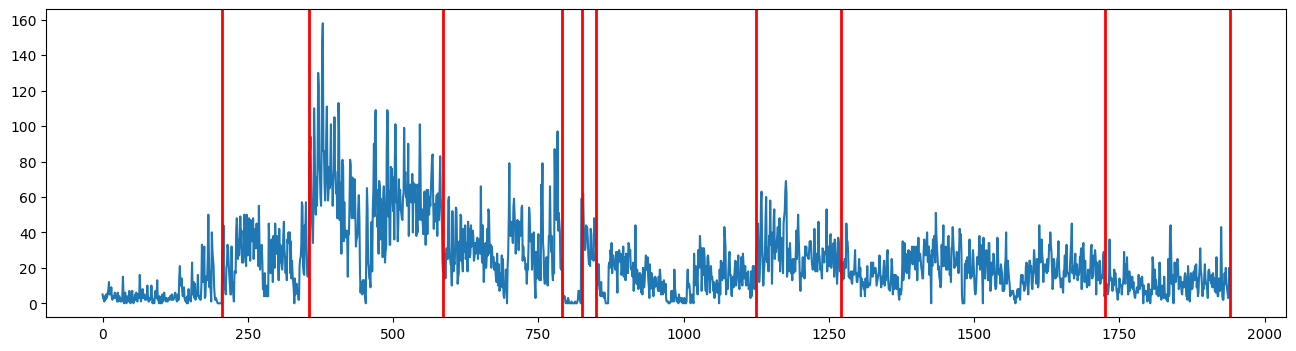

time: 1.83 s (started: 2024-05-14 07:35:13 +00:00)


In [ ]:
algo1 = rpt.Pelt(model="rbf").fit(temp_plot["SELL"].values)
change_location1 = algo1.predict(pen=10)
plot_change_points(temp_plot["SELL"].values,change_location1)

In [ ]:
change_location1

[205, 355, 585, 790, 825, 850, 1125, 1270, 1725, 1941]

time: 6.13 ms (started: 2024-05-14 07:36:06 +00:00)


In [ ]:
df_change_point = pd.DataFrame()

for key, df_group in tqdm(df_sample.groupby("ID")):
    cf = changefinder.ChangeFinder(r= 0.01, order= 3 , smooth= 5)
    df_group["ChangePoint_SDAR"] = [cf.update(p) for p in df_group["SELL"].tolist()]

    df_change_point = pd.concat([df_change_point, df_group[["ID","DATE", "ChangePoint_SDAR"]]])

100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]

time: 3min 28s (started: 2024-05-14 08:43:04 +00:00)


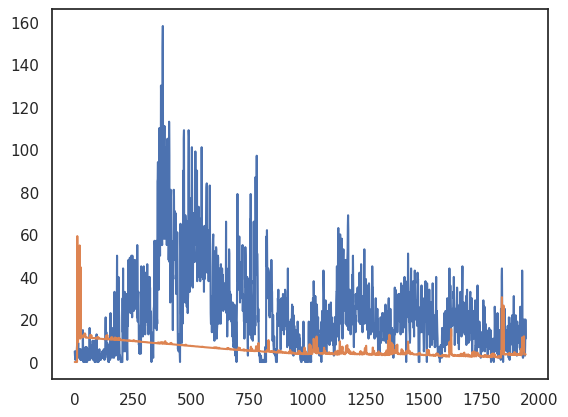

time: 966 ms (started: 2024-05-14 08:55:41 +00:00)


In [ ]:
temp_plot = df_change_point[df_change_point["ID"] == "FOODS_1_218_TX_2_evaluation"]
temp_plot = temp_plot.merge(
    df_sample[["ID","DATE","SELL"]],
    on = ["ID","DATE"],
    how = "left"
)
plt.plot(temp_plot["SELL"])
plt.plot(temp_plot["ChangePoint_SDAR"])

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(1280/96, 720/96), dpi=96)

for i, kernel in enumerate(['linear', 'rbf', 'cosine']):
    algo = rpt.KernelCPD(kernel=kernel, min_size=28)
    algo.fit(impressions)
    result = algo.predict(n_bkps=5)
    ax[i].plot(impressions)
    for bkp in result:
        ax[i].axvline(x=bkp, color='k', linestyle='--')
    ax[i].set_title(f"Kernel model with {kernel} kernel")
fig.tight_layout()

## Transform Sell

In [ ]:
# create baseline = MA +- MSTD
def create_smoothing_ts(df, target_var = "BCI", date_var = "Date", list_windowsize = [], list_ratio = []):
    df_group = df[[target_var, date_var]].copy()
    for windowsize in tqdm(list_windowsize):
        for ratio in list_ratio:
            df_group["MA"] = df_group[target_var].rolling(window=windowsize, min_periods = 1).mean()
            df_group["MSTD"] = df_group[target_var].rolling(window=windowsize, min_periods = 1).std()
            df_group["UPPER_BOUND"] = df_group["MA"] + ratio * df_group["MSTD"]
            df_group["LOWER_BOUND"] = df_group["MA"] - ratio * df_group["MSTD"]

            new_col_ts = f"{target_var}_smoothing_{windowsize}_{ratio}"
            df_group[new_col_ts] = df_group[target_var]
            df_group.loc[df_group[target_var] > df_group["UPPER_BOUND"], new_col_ts] = df_group[
                df_group[target_var] > df_group["UPPER_BOUND"]
            ]["UPPER_BOUND"]

            df_group.loc[df_group[target_var] < df_group["LOWER_BOUND"], new_col_ts] = df_group[
                df_group[target_var] < df_group["LOWER_BOUND"]
            ]["LOWER_BOUND"]

            df_group = df_group.drop(["MA","MSTD","UPPER_BOUND","LOWER_BOUND"], axis =1)

    return df_group

# Reduce memory usage

- **Numerical Columns:** Depending on your environment, pandas automatically creates int32, int64, float32 or float64 columns for numeric ones. If you know the min or max value of a column, you can use a subtype which is less memory consuming. You can also use an unsigned subtype if there is no negative value.Here are the different subtypes you can use:`int8 / uint8` : consumes 1 byte of memory, range between -128/127 or 0/255`bool` : consumes 1 byte, true or false`float16 / int16 / uint16`: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535`float32 / int32 / uint32` : consumes 4 bytes of memory, range between -2147483648 and 2147483647`float64 / int64 / uint64`: consumes 8 bytes of memoryIf one of your column has values between 1 and 10 for example, you will reduce the size of that column from 8 bytes per row to 1 byte, which is more than 85% memory saving on that column!

- **Categorical Columns:** Pandas stores categorical columns as objects. One of the reason this storage is not optimal is that it creates a list of pointers to the memory address of each value of your column. For columns with low cardinality (the amount of unique values is lower than 50% of the count of these values), this can be optimized by forcing pandas to use a virtual mapping table where all unique values are mapped via an integer instead of a pointer. This is done using the category datatype.

In [ ]:
def downcast(df):
    """
        Downcast in order to save memory
    """
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif (t == "O") or ("object" in str(t)):
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

time: 2.44 ms (started: 2024-06-24 14:22:23 +00:00)


# Model

## Methodologies

The data comprises 3049 individual products from 3 categories,  7 departments, sold in 10 stores in 3 states. The largest category is sales of all individual 3049 products per 10 stores for 30490 time series.

The training set from 2011-01-29 to 2016-05-22 and our target forecast horizon is 28 days until 2016-06-19. It also includes the IDs for item, department, category, store, and state.

**Forecast approaches**

There are many ways to forecast sell of product:

- Single-step prediction is used when the goal is to predict only the next value of the series.

- Multi-step forecasting: used when predict the whole future interval (n+1, n+2, ... n+t) or a far point at time (n+t). In this notebook, our forecast horizon is 28 days. Multi-step forecast have many methodologies

  - Recursive forecasting: the process is applied in which each new prediction, is based on the previous one. This strategy spend much cost (memory and time) to handle more than other approahces
  - Direct forecasting: consists of training a different model for each step of the forecast horizon
  - Hybrid direct-recursive: as it name =)) I'm not recommend to implement it
  - Multi-output forecasting: Some machine learning models, such as RNN can predict simultaneously several values of a sequence (one-shot).

- Multi-series forecasting (multivariate time series): above methods usually apply for univariate, multi-series forecasting is two or more time series are modeled together using a single model. There are two distinct strategies for multi-series forecasting.

  - Independent Multi-Series Forecasting: a single model is trained for all time series, but each time series remains independent of the others, meaning that past values of one series are not used as predictors of other series. However, modeling them together is useful because the series may follow the same intrinsic pattern regarding their past and future values.
  For instance, the sales of products A and B in the same store may not be related, but they follow the same dynamics, that of the store. In our context, machine learning is the good way to start this solution cause its can create features of past values independently of each series

  - Dependent Multi-Series Forecasting: all series are modeled together in a single model, considering that each time series depends not only on its past values but also on the past values of the other series.
  Nevertheless, I don't have enough information from M5-forecasting competition the define dependency among historical data sales of product so I won't use this method to approach problem

For more information: https://skforecast.org/0.10.1/introduction-forecasting/introduction-forecasting#direct-multi-step-forecasting


**Modeling multivariate and hierarchical time series**

A few differences exist between modeling and validating a regular ML problem (e.g., regression or classification) and a hierarchical time series forecasting problem with ML.

Modeling a hierarchical time series problem is similar to modeling a multivariate time series.

**Modeling multivariate time series** — Autoregressive and sequence-to-sequence models can usually only model one time series (univariate time series problem) at once. Thus, when encountering a multivariate time series problem (like hierarchical time series), we  have to build multiple forecasting models — one model for each time series.

Many competitors used LightGBM, an ML model and gradient-boosting framework, for modeling [1, 3, 5, 7, 8, 10]. When using LightGBM, you can model multiple time series with a single LightGBM model instead of building multiple forecasting models

Modeling strategies for multivariate time series (Image by the author)

Since the time series data is hierarchical, many competitors **grouped similar time series by hierarchy level** (e.g., by store) and modeled them together [3, 8, 10].



**Baseline model**

A baseline model is a simple model used to create a benchmark, or a point of reference, upon which you will be building your final, more complex machine learning model.

Data scientists create baseline models because:

- Baseline models can give you a good idea of how a more complex model will perform.
- If a baseline model does badly, it could be a sign of an issue with the data quality that needs addressing.
- If a baseline model performs better than the final model, it could indicate issues with that algorithm, features, hyperparameters or other data preprocessing.
- If the baseline and complex model perform more or less the same, this could indicate that the complex model needs more fine tuning (in features, architecture, or hyperparameters). It could also show that a more complex model isn't necessary, and a simpler model will suffice.

Typically, a baseline model is a statistical model, such as a moving average model. Alternatively, it is a simpler version of the target model — for example, if you will be training a Random Forest model, you can first train a Decision Tree model as a baseline.

If you were to try and forecast 30 days into the future, a true naive forecast would assume that the next 30 days are the same as the last day or the last data point. This would result in a flat line forecast. The same is true for moving average. Because of this, these techniques aren't optimal for actually forecasting out long periods of time. However, they are still valuable tools for establishing a baseline and benchmarking what decent performance might look like on a final model.

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error as MAE,\
                            mean_squared_error as MSE,\
                            mean_absolute_percentage_error as MAPE, \
                            r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from pmdarima.arima import auto_arima
from prophet import Prophet
from statsmodels.tsa.vector_ar.var_model import VAR

time: 2.37 s (started: 2024-06-24 14:23:03 +00:00)


In [ ]:
def evaluate_performance(ground_truth, predicted_values):
    print("MAE", MAE(ground_truth, predicted_values))
		# squared, default=True. If True returns MSE value, if False returns RMSE value.
    print("RMSE", MSE(ground_truth, predicted_values, squared = False))
    print("MSE", MSE(ground_truth, predicted_values, squared = True))
		# use log when scale of target values is very large
    print("MAPE", MAPE(ground_truth, predicted_values))
    print("R2_score", r2_score(ground_truth, predicted_values))


def accuracy_check(
        df_group: pd.DataFrame,
        key = "overall",
        ground_truth = "SELL",
        predict_col_arr = None,
        start_date = "2016-01-01",
        end_date = "2016-05-22",
):
    df_group[ground_truth] = df_group[ground_truth].fillna(0)

    performance = dict()
    performance = {"CATEGORY": key, "Sum_actual": df_group[ground_truth].sum()}
    performance["Mean_actual"] = df_group[ground_truth].mean()
    performance["Std_actual"] = df_group[ground_truth].std()

    for predict_col in predict_col_arr:
        df_group[predict_col] = df_group[predict_col].fillna(0)
        df_group[predict_col] = df_group[predict_col].replace([-np.inf, np.inf], 0)

        performance["Sum_predict_" + predict_col] = df_group[predict_col].sum()
        performance["Mean_predict_" + predict_col] = df_group[predict_col].mean()
        performance["MAE_" + predict_col] = MAE(
            df_group[ground_truth], df_group[predict_col]
        )
        performance["RMSE_" + predict_col] = MSE(
            df_group[ground_truth], df_group[predict_col], squared=False
        )
        performance["MAPE_" + predict_col] = MAPE(
            df_group[ground_truth], df_group[predict_col]
        )

    return performance


def plot_performance(
        df: pd.DataFrame,
        ground_truth: str = "SELL",
        predict_col_arr = None,
        start_date = "2016-01-01",
        end_date = "2016-05-22"
):
    df = df[df["DATE"].between(start_date, end_date)]
    df[ground_truth] = df[ground_truth].fillna(0)

    for pred in predict_col_arr:
        df[pred] = df[pred].replace([-np.inf, np.inf]).fillna(0)
        print(ground_truth, " vs ", pred)
        evaluate_performance(df[ground_truth], df[pred])

    fig = go.Figure(
        data = [
            go.Scatter(
                x = df["DATE"],
                y = df[ground_truth],
                name = "Actual Sell",
                connectgaps = False,
                marker = {"color": "blue"},
                mode = "lines+markers",
            )
        ]
    )
    for pred in predict_col_arr:
        fig.add_trace(
            go.Scatter(x = df["DATE"], y = df[pred], name = "Predicted Sell from" + pred)
        )

    fig.update_layout(title="Line chart of actual vs forecast Sell", hovermode= "x unified")
    fig.show()

time: 3.88 ms (started: 2024-06-24 14:23:05 +00:00)


In [ ]:
def plot_decomposition(df, start_date = "2011-01-01", end_date = "2016-12-31", period = 7):
    df = df[df["DATE"].between(start_date, end_date)]
    ts = df.set_index("DATE").asfreq("D")["SELL"]

    ma_decompose = seasonal_decompose(ts, model='additive', period=period)
    ma_decompose.plot()
    plt.legend(title = "Additive Seasonal decomposition")

    ma_decompose = seasonal_decompose(ts, model='multiplicative', period=period)
    ma_decompose.plot()
    plt.legend(title = "Multiplicative Seasonal decomposition")

    loess_decompose = STL(ts, seasonal = period).fit()
    loess_decompose.plot()
    plt.legend(title = "LOESS decomposition")
    plt.show()

def test_stationary(df, series = 'SELL', windowsize=7):
    # Rolling statistics
    movingAverage = df[series].rolling(window=windowsize).mean()
    movingSTD = df[series].rolling(window=windowsize).std()

    fig = go.Figure(
        data = [
            go.Scatter(x = df['DATE'], y = df[series], mode = 'lines',
                    name = series, line = dict(color = 'blue')),
            go.Scatter(x = df['DATE'], y = movingAverage, mode='lines',
                            name = 'Rolling Mean', line = dict(color = 'red')),
            go.Scatter(x = df['DATE'], y = movingSTD, mode = 'lines',
                    name = 'Rolling Std', line = dict(color = 'black'))
        ]
    )
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='Sale')
    fig.update_layout(title='Rolling Mean & Standard Deviation')
    fig.show()

    # Dickey Fuller test
    print('Results of Dickey Fuller Test:\n')
    stable_test = adfuller(df[series], autolag='AIC')
    df_test = pd.Series(stable_test [0:4],
                        index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
    for key, value in stable_test[4].items():
        df_test['Critical Value (%s)' %key] = value
    print(df_test)

    # Hypothesis Testing
    if stable_test[0] < stable_test[4]['5%']:
        print('Reject Ho — Time Series is Stationary!')
    else:
        print('Accept Ho — Time Series is not Stationary!')

time: 3.08 ms (started: 2024-06-24 14:23:05 +00:00)


## Univariate time series

### Statistical model

Experiment recursive and direct multi-step forecasting method



https://medium.com/analytics-vidhya/a-thorough-introduction-to-arima-models-987a24e9ff71

https://towardsdatascience.com/time-series-models-d9266f8ac7b0

https://freedium.cfd/https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d

#### ARIMA & Seasonal ARIMA

Plot the data and identify unsual observations. Understand the pattern (trend, seasonality, cycle) of the data.

Apply a transormation or differencing to remove the trend and stabilize the variance

Test for stationarity. If the series is not stationary, apply another transformation or differencing.

Plot the ACF and PACF to maybe estimate the order of the MA or AR process.

Try different combinations of orders and select the model with the lowest AIC.

Check the residuals and make sure that they look like white noise.

Apply the Ljung-Box test to make sure.
Calculate forecasts.

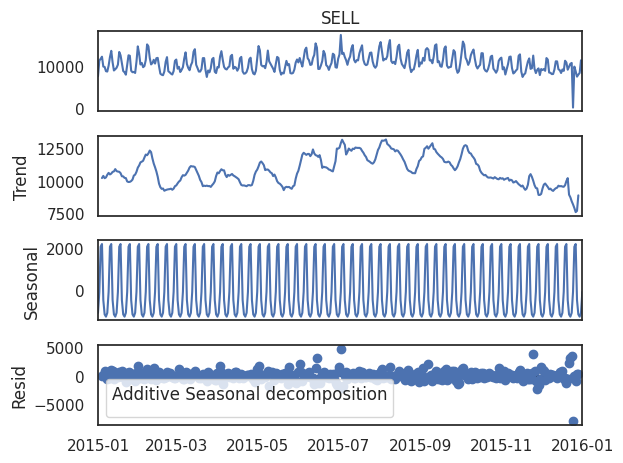

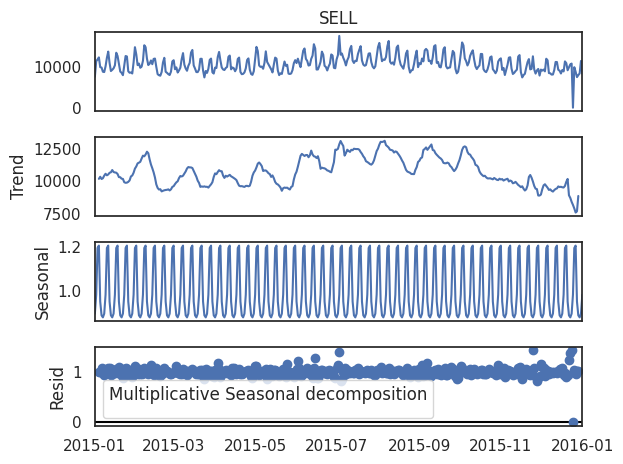

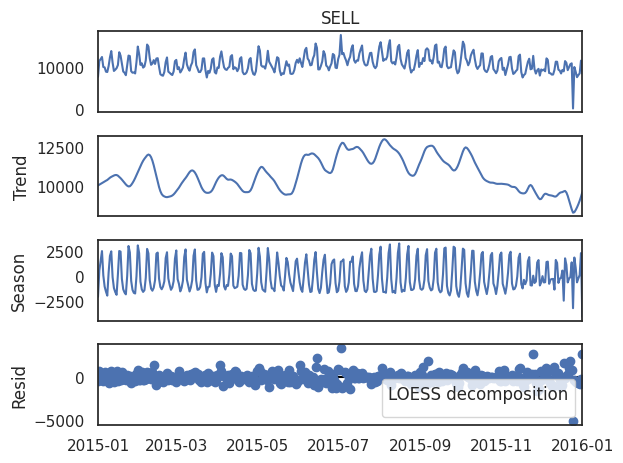

time: 7.69 s (started: 2024-05-07 09:45:10 +00:00)


In [ ]:
temp_plot = df_sample.groupby("DATE")["SELL"].sum().reset_index()
plot_decomposition(temp_plot, start_date = "2015-01-01", end_date = "2016-01-01", period = 7)

As I already EDA,data have a very strong seasonality by weekly (period = 7 days). Even I have change sample to have diverse view, all seasonal and LOESS decomposition return the same trend and seasonal

Now lets check stationary and autocorrelation to define parameters of ARIMA and Seasonal ARIMA

In [ ]:
temp_plot = df_sample.groupby("DATE")["SELL"].mean().reset_index()
test_stationary(temp_plot, series = "SELL", windowsize = 7)

temp_plot["DIFF_1"] = temp_plot["SELL"].diff(1).fillna(0)
test_stationary(temp_plot, series = "DIFF_1", windowsize = 7)

Results of Dickey Fuller Test:

Test Statistic                   -2.309520
p-value                           0.168916
No. of Lags used                 26.000000
Number of observations used    1914.000000
Critical Value (1%)              -3.433771
Critical Value (5%)              -2.863051
Critical Value (10%)             -2.567575
dtype: float64
Accept Ho — Time Series is not Stationary!


Results of Dickey Fuller Test:

Test Statistic                  -20.252077
p-value                           0.000000
No. of Lags used                 26.000000
Number of observations used    1914.000000
Critical Value (1%)              -3.433771
Critical Value (5%)              -2.863051
Critical Value (10%)             -2.567575
dtype: float64
Reject Ho — Time Series is Stationary!
time: 528 ms (started: 2024-05-07 09:45:19 +00:00)


From the hypothesis testing, total items of data are not stationary. After transform by using difference, pattern is stationary => parameter d for ARIMA = 1

Now lets check parameter of AR and MA by following PACF and ACF

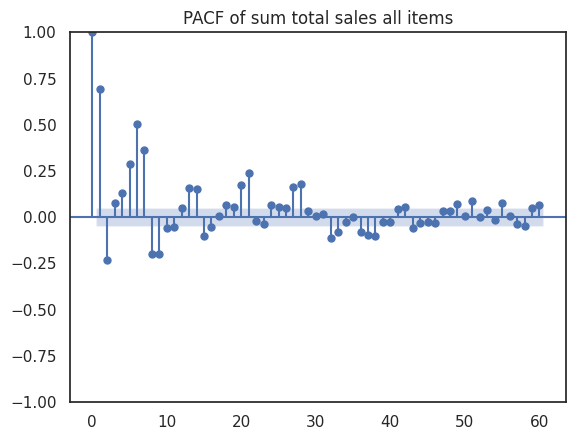

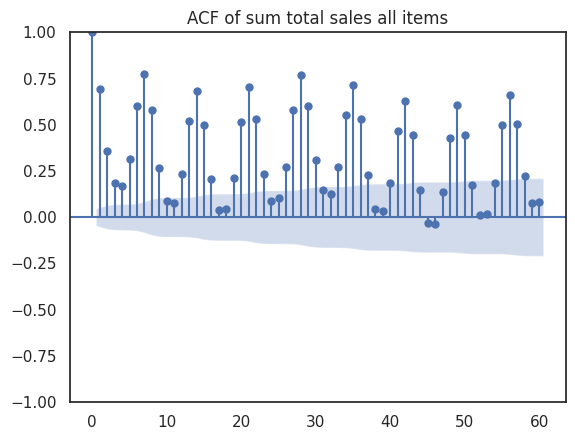

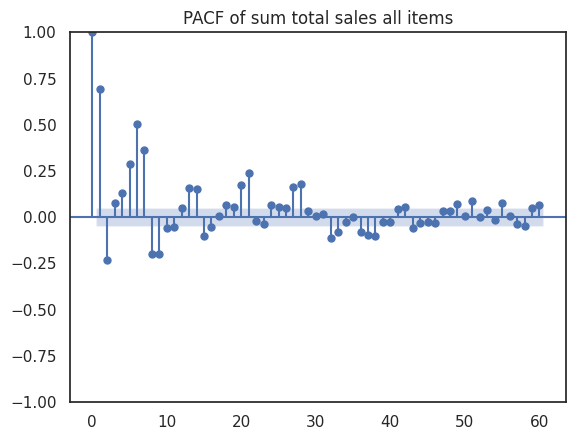

time: 4.13 s (started: 2024-05-07 10:03:58 +00:00)


In [ ]:
df_agg_acf = df_sample[(df_sample["DATE"].between("2011-01-29", "2015-12-31"))].groupby(["DATE"])["SELL"].mean().reset_index()

plot_acf(df_agg_acf["SELL"], lags = 60, title = "ACF of sum total sales all items")
plot_pacf(df_agg_acf["SELL"], lags = 60, title = "PACF of sum total sales all items")

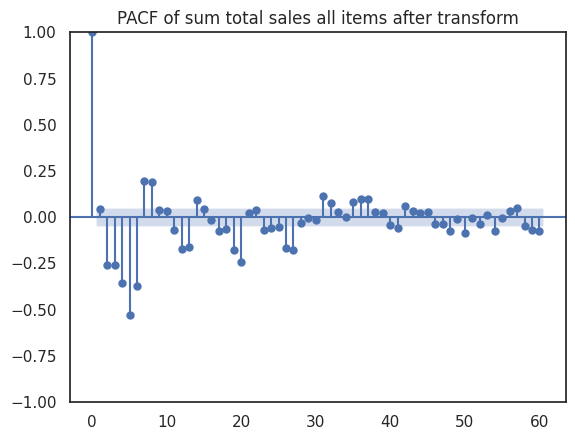

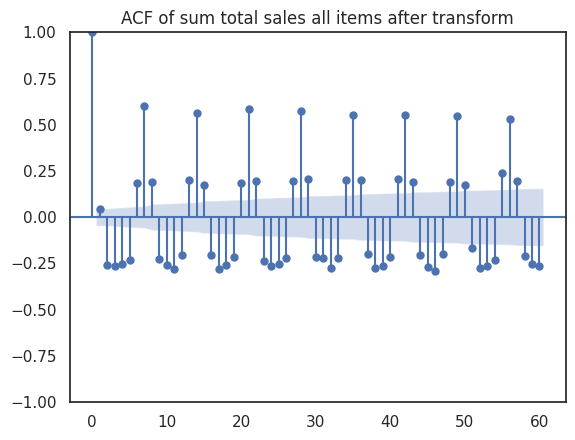

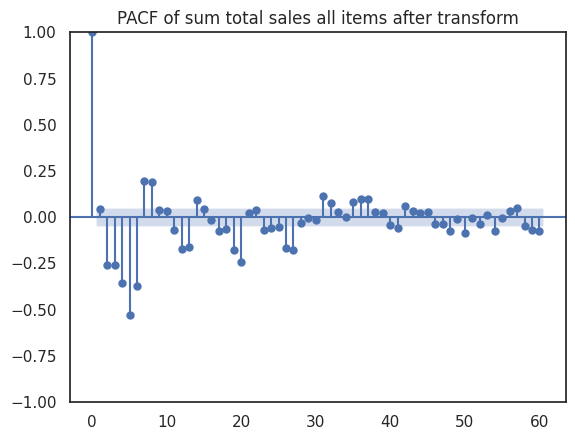

time: 3 s (started: 2024-05-07 10:04:02 +00:00)


In [ ]:
df_agg_acf["DIFF_1"] = df_agg_acf["SELL"].diff(1).fillna(0)

plot_acf(df_agg_acf["DIFF_1"], lags = 60, title = "ACF of sum total sales all items after transform")
plot_pacf(df_agg_acf["DIFF_1"], lags = 60, title = "PACF of sum total sales all items after transform")

From above we can identify its have seasonal m = 7
PACF refer AutoRegressive 1 day and seasonal AR can be 1 to 4

ACF refer MovingAverage 1-4 and seasonal MA can have a long range but I tuning to 4 avoid overfitting

In [ ]:
df_agg_uni = df_sample.groupby(["DATE"])["SELL"].mean().reset_index()
print(df_agg_uni["DATE"].min(), df_agg_uni["DATE"].max())
df_agg_uni.head(3)

2011-01-29 00:00:00 2016-05-22 00:00:00


DATE    SELL
0 2011-01-29  11.959
1 2011-01-30  11.848
2 2011-01-31   8.886

time: 130 ms (started: 2024-05-07 10:06:51 +00:00)


In [ ]:
model_arima = auto_arima(
    df_agg_uni["SELL"][df_agg_uni["DATE"].between("2011-01-29", "2015-12-31")],
    start_p=1, max_p = 2,
    d=1,
    start_q=1, max_q = 4,
    max_order= 5, #max_order for constrant paramater tuning with: p + q + P + Q <= max_order
    stationary=False, information_criterion='aic', scoring = "mse",
    n_jobs = -1, random_state = 42, trace = True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7241.424, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7667.867, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7666.548, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7663.490, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7665.867, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6963.615, Time=3.76 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7542.659, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6714.863, Time=2.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7077.564, Time=3.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.43 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7042.251, Time=4.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6712.864, Time=0.93 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7075.568, Time=0.70 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6961.617, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0]             : 

In [ ]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1798
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -3351.432
Date:                Tue, 07 May 2024   AIC                           6712.864
Time:                        10:07:39   BIC                           6740.333
Sample:                             0   HQIC                          6723.005
                               - 1798                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1603      0.017     67.213      0.000       1.126       1.194
ar.L2         -0.8307      0.013    -63.469      0.000      -0.856      -0.805
ma.L1         -1.4524      0.021    -69.849      0.000      -1.493      -1.412
ma.L2          0.7319      0.021     34.745      0.000       0.691       0.773
sigma2         2.4374      0.042     58.554      0.000       2.356       2.519
===================================================================================
Ljung-Box (L1) (Q):                  23.77   Jarque-Bera (JB):              4384.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.38
Prob(H) (two-sided):                  0.76   Kurtosis:                        10.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

time: 39.7 ms (started: 2024-05-07 10:07:39 +00:00)


In [ ]:
univariate_ts = df_agg_uni[df_agg_uni["DATE"] < "2016-01-01"].set_index("DATE")["SELL"].asfreq("D")

model_arima = SARIMAX(univariate_ts, order = (2,1,2)).fit()
y_pred = model_arima.predict(start = "2016-01-01", end = "2016-05-22")
df_agg_uni["auto_arima"] = 0
df_agg_uni["auto_arima"][df_agg_uni["DATE"] >= "2016-01-01"] = y_pred.values

plot_performance(df_agg_uni, ground_truth ="SELL", predict_col_arr = ["auto_arima"])

SELL  vs  auto_arima
MAE 2.2648401418755566
RMSE 2.882407593492614
MSE 8.308273535023881
MAPE 0.18487793264479385
R2_score -1.326613175035643


time: 1.16 s (started: 2024-05-07 10:08:17 +00:00)


In [ ]:
df_result = pd.DataFrame()

for key, df_group in tqdm(df_sample.groupby("ID")):
    df_group = df_group[["ID","DATE", "SELL"]].sort_values("DATE").reset_index(drop = True)
    df_group["ARIMA"] = np.nan
    df_group["ERROR_ARIMA"] = np.nan

    univariate_ts = df_group[df_group["DATE"] < "2016-01-01"].set_index("DATE")["SELL"].asfreq("D")
    order_tuning = (2, 1, 2)

    try:
        model = SARIMAX(univariate_ts, order = order_tuning).fit() #.fit(maxiter = 200, method_kwargs={"warn_convergence": False})
        y_pred = model.predict(start = "2016-01-01", end = "2016-05-22")
        df_group["ARIMA"][df_group["DATE"] >= "2016-01-01"] = y_pred.values
    except Exception as e:
        df_group["ERROR_ARIMA"] = str(e)

    df_result = pd.concat([df_result, df_group])

100%|██████████| 1000/1000 [18:03<00:00,  1.08s/it]

time: 18min 3s (started: 2024-05-07 10:14:59 +00:00)


In [ ]:
display(df_result.head(3))
display(df_result.describe())

ID       DATE  SELL  ARIMA  ERROR_ARIMA
0  FOODS_1_004_CA_1_evaluation 2011-01-29   0.0    NaN          NaN
1  FOODS_1_004_CA_1_evaluation 2011-01-30   0.0    NaN          NaN
2  FOODS_1_004_CA_1_evaluation 2011-01-31   0.0    NaN          NaN

SELL          ARIMA  ERROR_ARIMA
count  1.941000e+06  143000.000000          0.0
mean   1.139443e+01       9.272622          NaN
std    1.553195e+01       9.669944          NaN
min    0.000000e+00      -0.115301          NaN
25%    2.000000e+00       3.906982          NaN
50%    8.000000e+00       7.111637          NaN
75%    1.500000e+01      11.408079          NaN
max    7.630000e+02     117.316512          NaN

time: 228 ms (started: 2024-05-07 10:33:02 +00:00)


In [ ]:
display(accuracy_check(df_result, ground_truth = "SELL", predict_col_arr = ["ARIMA"]))

# plot_temp = df_result[df_result["ID"] == "FOODS_1_218_TX_2_evaluation"]
plot_temp = df_result.groupby("DATE")["SELL","ARIMA"].sum().reset_index()

plot_performance(plot_temp, ground_truth = "SELL", predict_col_arr = ["ARIMA"])

{'CATEGORY': 'overall',
 'Sum_actual': 22116584.0,
 'Mean_actual': 11.394427614631633,
 'Std_actual': 15.531953863386246,
 'Sum_predict_ARIMA': 1325984.8952888367,
 'Mean_predict_ARIMA': 0.6831452319880663,
 'MAE_ARIMA': 11.070600672455075,
 'RMSE_ARIMA': 18.959106941952818,
 'MAPE_ARIMA': 242634718988260.12}

SELL  vs  ARIMA
MAE 2031.8422854759203
RMSE 2647.8301926272593
MSE 7011004.728988509
MAPE 0.1645331145096146
R2_score -0.9633315999934726


time: 564 ms (started: 2024-05-07 10:33:04 +00:00)


In [ ]:
df_total_result_model = df_total_result_model.merge(df_result, on = ["ID","DATE","SELL"], how = "left")
print(df_total_result_model.shape)
df_total_result_model.head(3)

(1941000, 5)


ID       DATE  SELL  ARIMA  ERROR_ARIMA
0  FOODS_1_004_CA_1_evaluation 2011-01-29   0.0    0.0          NaN
1  FOODS_1_004_CA_1_evaluation 2011-01-30   0.0    0.0          NaN
2  FOODS_1_004_CA_1_evaluation 2011-01-31   0.0    0.0          NaN

time: 1.3 s (started: 2024-05-07 10:34:40 +00:00)


Non-seasonal behavior: The PACF shows a clear spike at lag 1 and not much else until about lag 11. This is accompanied by a tapering pattern in the early lags of the ACF. A non-seasonal AR(1) may be a useful part of the model.

Seasonal behavior: We look at what’s going on around lags 7, 14, and so on. In the ACF, there’s a cluster of (negative) spikes around lag 12 and then not much else. The PACF tapers in multiples of S; that is the PACF has significant lags at 7, 14, 21 and so on

(2, 1, 2)x(1, 0, 1, 7)


In [ ]:
model_sarima = auto_arima(
    df_agg_uni["SELL"][df_agg_uni["DATE"].between("2011-01-29", "2015-12-31")],
    start_p=1, max_p = 2,
    d=None, max_d = 1,
    start_q=1, max_q = 4,
    start_P=0, max_P = 2,
    D=None, max_D = 1,
    start_Q=0, max_Q = 8,
    m=7, seasonal = True,
    max_order= 30, #max_order for constrant paramater tuning with: p + q + P + Q<= max_order
    stationary=False, information_criterion='aic', scoring = "mse",
    n_jobs = -1, random_state = 42, trace = True
)

In [ ]:
model_sarima.summary()

In [ ]:
univariate_ts = df_agg_uni[df_agg_uni["DATE"] < "2016-01-01"].set_index("DATE")["SELL"].asfreq("D")

model_sarima = SARIMAX(univariate_ts, order = (2,1,3), seasonal_order = (2, 0, 1, 7)).fit()
y_pred = model_sarima.predict(start = "2016-01-01", end = "2016-05-22")
df_agg_uni["auto_sarima"] = 0
df_agg_uni["auto_sarima"][df_agg_uni["DATE"] >= "2016-01-01"] = y_pred.values

plot_performance(df_agg_uni, ground_truth ="SELL", predict_col_arr = ["auto_sarima"])

In [ ]:
df_result = pd.DataFrame()

for key, df_group in tqdm(df_sample.groupby("ID")):
    df_group = df_group[["ID","DATE", "SELL"]].sort_values("DATE").reset_index(drop = True)
    df_group["SARIMA"] = np.nan
    df_group["ERROR_SARIMA"] = np.nan

    univariate_ts = df_group[df_group["DATE"] < "2016-01-01"].set_index("DATE")["SELL"].asfreq("D")
    order_tuning = (14, 1, 3)
    seasonal_order_tuning = (2, 0, 0, 7)

    try:
        model = SARIMAX(
            univariate_ts,
            order = order_tuning,
            seasonal_order = seasonal_order_tuning
        ).fit() #.fit(maxiter = 200, method_kwargs={"warn_convergence": False})
        y_pred = model.predict(start = "2016-01-01", end = "2016-05-22")
        df_group["SARIMA"][df_group["DATE"] >= "2016-01-01"] = y_pred.values
    except Exception as e:
        df_group["ERROR_SARIMA"] = str(e)

    df_result = pd.concat([df_result, df_group])

In [ ]:
display(df_result.head(3))
df_result.describe()

In [ ]:
display(accuracy_check(df_result, ground_truth = "SELL", predict_col_arr = ["SARIMA"]))

# plot_temp = df_result[df_result["ID"] == "FOODS_1_218_TX_2_evaluation"]
plot_temp = df_result.groupby("DATE")["SELL","SARIMA"].sum().reset_index()

plot_performance(plot_temp, ground_truth = "SELL", predict_col_arr = ["SARIMA"])

In [ ]:
df_total_result_model = df_total_result_model.merge(df_result, on = ["ID","DATE","SELL"], how = "left")
print(df_total_result_model.shape)
df_total_result_model.head(3)

#### Expotional Smoothing

https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

In [ ]:
# from sktime.forecasting.ets import AutoETS

def tuning_ETS(series):
    results = []
    for trend in ["add","mul"]:
        for season in ["add","mul"]:
            for damped in [True, False]:
                for boxcox in [True, False]:
                    try:
                        model = ExponentialSmoothing(
                            series,
                            trend = trend,
                            seasonal = season,
                            seasonal_periods = 7,
                            use_boxcox = boxcox,
                        ).fit()
                        results.append([trend, season, damped, boxcox, model.aic, model.bic])
                    except:
                        continue

    result_df = pd.DataFrame(results)
    result_df.columns = ["trend","seasonal","damped_trend", "use_boxcox", "AIC", "BIC"]
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

time: 1.51 ms (started: 2024-03-23 10:31:22 +00:00)


In [ ]:
ts = df_agg_uni.set_index("DATE").asfreq("D")["SELL"]

display(tuning_ETS(ts))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



trend seasonal  damped_trend  use_boxcox          AIC          BIC
0    mul      mul          True       False  5567.741421  5629.021965
1    mul      mul         False       False  5567.741421  5629.021965
2    add      mul          True       False  5569.111109  5630.391654
3    add      mul         False       False  5569.111109  5630.391654
4    mul      add          True        True  5579.482035  5640.762580
5    mul      add         False        True  5579.482035  5640.762580
6    add      add          True        True  5585.151830  5646.432374
7    add      add         False        True  5585.151830  5646.432374
8    mul      mul          True        True  5592.105157  5653.385701
9    mul      mul         False        True  5592.105157  5653.385701
10   add      mul          True        True  5592.171992  5653.452536
11   add      mul         False        True  5592.171992  5653.452536
12   mul      add          True       False  5607.371080  5668.651624
13   mul      add         False       False  5607.371080  5668.651624
14   add      add          True       False  5611.222420  5672.502964
15   add      add         False       False  5611.222420  5672.502964

time: 24 s (started: 2024-03-23 10:31:24 +00:00)


In [ ]:
ts = df_agg_uni.set_index("DATE").asfreq("D")["SELL"]
model_ETS = ExponentialSmoothing(ts, trend = "mul", seasonal = "mul", damped_trend = True, seasonal_periods = 7).fit()
model_ETS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                     SELL   No. Observations:                 1941
Model:             ExponentialSmoothing   SSE                          33813.396
Optimized:                         True   AIC                           5570.706
Trend:                   Multiplicative   BIC                           5637.557
Seasonal:                Multiplicative   AICC                          5570.924
Seasonal Periods:                     7   Date:                 Sat, 23 Mar 2024
Box-Cox:                          False   Time:                         10:16:50
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4060671                alpha                 True
smoothing_trend              2.3493e-05                 beta                 True
smoothing_seasonal           4.5927e-05                gamma                 True
initial_level                 25.002065                  l.0                 True
initial_trend                 0.9941819                  b.0                 True
damping_trend                 0.9704861                  phi                 True
initial_seasons.0             1.7224451                  s.0                 True
initial_seasons.1             1.6781840                  s.1                 True
initial_seasons.2             1.2926442                  s.2                 True
initial_seasons.3             1.1971297                  s.3                 True
initial_seasons.4             1.1936190                  s.4                 True
initial_seasons.5             1.2292638                  s.5                 True
initial_seasons.6             1.4087465                  s.6                 True
---------------------------------------------------------------------------------
"""

time: 4.33 s (started: 2024-03-23 10:16:46 +00:00)


In [ ]:
y_pred = model_ETS.predict(start = "2016-01-01", end = "2016-05-22")
df_result = df_agg_uni.copy()
df_result["ETS"] = 0
df_result["ETS"][df_result["DATE"].between("2016-01-01", "2016-05-22")] = y_pred.values
plot_performance(df_result, ground_truth = "SELL", predict_col_arr = ["ETS"])

SELL  vs  ETS
MAE 2.0888339209541353
RMSE 2.771062398660637
MSE 7.6787868172708444
MAPE 0.07068375420190502
R2_score 0.7845120780911639


time: 425 ms (started: 2024-03-23 10:19:57 +00:00)


In [ ]:
df_result = pd.DataFrame()

for key, df_group in tqdm(df_sample.groupby("ID")):
    df_group = df_group[["ID","DATE", "SELL"]].sort_values("DATE").reset_index(drop = True)
    df_group["ETS"] = np.nan
    df_group["ERROR_ETS"] = np.nan

    univariate_ts = df_group[df_group["DATE"] < "2016-01-01"].set_index("DATE")["SELL"].asfreq("D")
    try:
        # endog must be strictly positive when usingmultiplicative trend or seasonal components.
        model = ExponentialSmoothing(univariate_ts, trend='add', seasonal="add", damped_trend = True, seasonal_periods=7).fit()
        y_pred = model.predict(start = "2016-01-01", end = "2016-05-22")
        df_group["ETS"][df_group["DATE"] >= "2016-01-01"] = y_pred.values
    except Exception as e:
        df_group["ERROR_ETS"] = str(e)

    df_result = pd.concat([df_result, df_group])

100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

time: 47.8 s (started: 2024-03-23 10:47:16 +00:00)


In [ ]:
display(df_result.head(3))
df_result.describe()

ID       DATE  SELL  ETS  ERROR_ETS
0  FOODS_1_218_TX_2_evaluation 2011-01-29   5.0  NaN        NaN
1  FOODS_1_218_TX_2_evaluation 2011-01-30   3.0  NaN        NaN
2  FOODS_1_218_TX_2_evaluation 2011-01-31   2.0  NaN        NaN

SELL           ETS  ERROR_ETS
count  194100.000000  14300.000000        0.0
mean       32.604462     23.702389        NaN
std        31.420985     22.556988        NaN
min         0.000000    -49.822325        NaN
25%        14.000000      9.138635        NaN
50%        26.000000     20.672335        NaN
75%        43.000000     33.613508        NaN
max       763.000000    117.273753        NaN

time: 196 ms (started: 2024-03-23 10:48:04 +00:00)


In [ ]:
display(accuracy_check(df_result, ground_truth = "SELL", predict_col_arr = ["ETS"]))

# plot_temp = df_result[df_result["ID"] == "FOODS_1_218_TX_2_evaluation"]
plot_temp = df_result.groupby("DATE")["SELL","ETS"].sum().reset_index()
plot_performance(plot_temp, ground_truth = "SELL", predict_col_arr = ["ETS"])

{'CATEGORY': 'overall',
 'Sum_actual': 6328526.0,
 'Mean_actual': 32.604461617722826,
 'Std_actual': 31.42098454916215,
 'Sum_predict_ETS': 338944.16545320983,
 'Mean_predict_ETS': 1.7462347524637292,
 'MAE_ETS': 31.66620252527573,
 'RMSE_ETS': 44.72883526941923}

SELL  vs  ETS
MAE 625.6672039729125
RMSE 698.9929809959431
MSE 488591.18748159485
MAPE 0.20410639364168065
R2_score -0.3711215346749197


time: 150 ms (started: 2024-03-23 10:48:04 +00:00)


In [ ]:
df_total_result_model = df_total_result_model.merge(df_result, on = ["ID","DATE","SELL"], how = "left")
print(df_total_result_model.shape)
df_total_result_model.head(3)

ID       DATE  SELL  ARIMA  ERROR_ARIMA  ETS  \
0  FOODS_1_218_TX_2_evaluation 2011-01-29   5.0    0.0          NaN  0.0   
1  FOODS_1_218_TX_2_evaluation 2011-01-30   3.0    0.0          NaN  0.0   
2  FOODS_1_218_TX_2_evaluation 2011-01-31   2.0    0.0          NaN  0.0   

   ERROR_ETS  
0        NaN  
1        NaN  
2        NaN

time: 30.9 ms (started: 2024-03-23 10:48:14 +00:00)


## Multivariate time series

https://python.plainenglish.io/a-look-at-multivariate-forecast-8669fb0f557c

https://medium.com/@evagian/multiple-timeseries-forecasting-c59da34dc4b8


### Statistical model

https://freedium.cfd/https://towardsdatascience.com/train-multiple-time-series-forecasting-models-in-one-line-of-python-code-615f2253b67a

#### Auto_Timeseries tuning

Start of Fit.....
    Target variable given as = SELL
Start of loading of data.....
    Inputs: ts_column = DATE, sep = ,, target = ['SELL']
    Using given input: pandas dataframe...
    DATE column exists in given train data...
    train data shape = (1798, 1)
Alert: Could not detect strf_time_format of DATE. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is stationary after one differencing
There is 1 differencing needed in this datasets for VAR model
    No time series plot since verbose = 0. Continuing
Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/_mqv5v5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/itep9gqy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61598', 'data', 'file=/tmp/tmp331b9rbg/_mqv5v5a.json', 'init=/tmp/tmp331b9rbg/itep9gqy.json', 'output', 'file=/tmp/tmp331b9rbg/prophet_model7lw2omkd/prophet_model-20240508064859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
06:48:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


kwargs for Prophet model: {'iter': 100}
  Starting Prophet Fit
       Adding daily seasonality to Prophet with period=7, fourier_order=15 and prior_scale=0.10
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 1773 Test Shape: 5


06:48:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/kn8_eg1s.json


    RMSE = 0.40
    Std Deviation of actuals = 0.40
    Normalized RMSE (as pct of std dev) = 99%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 1778 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/fsh6d0xd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17553', 'data', 'file=/tmp/tmp331b9rbg/kn8_eg1s.json', 'init=/tmp/tmp331b9rbg/fsh6d0xd.json', 'output', 'file=/tmp/tmp331b9rbg/prophet_modelvw3xxwfa/prophet_model-20240508064900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
06:49:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:49:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/lzo351in.json


    RMSE = 0.63
    Std Deviation of actuals = 1.15
    Normalized RMSE (as pct of std dev) = 54%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 1783 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/ixa8g6yo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77490', 'data', 'file=/tmp/tmp331b9rbg/lzo351in.json', 'init=/tmp/tmp331b9rbg/ixa8g6yo.json', 'output', 'file=/tmp/tmp331b9rbg/prophet_modela7l8jtcx/prophet_model-20240508064900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
06:49:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:49:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/jxc_dir5.json


    RMSE = 0.88
    Std Deviation of actuals = 1.01
    Normalized RMSE (as pct of std dev) = 87%
Cross Validation window: 3 completed

Fold Number: 4 --> Train Shape: 1788 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/dd42ih2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46806', 'data', 'file=/tmp/tmp331b9rbg/jxc_dir5.json', 'init=/tmp/tmp331b9rbg/dd42ih2i.json', 'output', 'file=/tmp/tmp331b9rbg/prophet_modelzkgmh5tl/prophet_model-20240508064901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
06:49:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:49:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/v51m3u1c.json


    RMSE = 4.85
    Std Deviation of actuals = 4.12
    Normalized RMSE (as pct of std dev) = 118%
Cross Validation window: 4 completed

Fold Number: 5 --> Train Shape: 1793 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/4ck2fc0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10057', 'data', 'file=/tmp/tmp331b9rbg/v51m3u1c.json', 'init=/tmp/tmp331b9rbg/4ck2fc0p.json', 'output', 'file=/tmp/tmp331b9rbg/prophet_modeln8nlj9e1/prophet_model-20240508064902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
06:49:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:49:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 2.13
    Std Deviation of actuals = 1.38
    Normalized RMSE (as pct of std dev) = 155%
Cross Validation window: 5 completed

-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 1.39
    MSE (Mean Squared Error = 5.88
    MAPE (Mean Absolute Percent Error) = 4014%
    RMSE (Root Mean Squared Error) = 2.4243
    Normalized RMSE (MinMax) = 21%
    Normalized RMSE (as Std Dev of Actuals)= 109%
Time Taken = 6 seconds


DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/mwxbrl3d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/35r3nem4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36028', 'data', 'file=/tmp/tmp331b9rbg/mwxbrl3d.json', 'init=/tmp/tmp331b9rbg/35r3nem4.json', 'output', 'file=/tmp/tmp331b9rbg/prophet_modela9qj3lzf/prophet_model-20240508064905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
06:49:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:49:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  End of Prophet Fit


Building Auto SARIMAX Model



Running Auto SARIMAX Model...
    Using smaller parameters for larger dataset with greater than 1000 samples
    Using smaller parameters for larger dataset with greater than 1000 samples
    Using smaller parameters for larger dataset with greater than 1000 samples
    Using smaller parameters for larger dataset with greater than 1000 samples
    Using smaller parameters for larger dataset with greater than 1000 samples

SARIMAX RMSE (all folds): 1.5752
SARIMAX Norm RMSE (all folds): 61%


-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 1.16
    MSE (Mean Squared Error = 4.64
    MAPE (Mean Absolute Percent Error) = 3762%
    RMSE (Root Mean Squared Error) = 2.1530
    Normalized RMSE (MinMax) = 19%
    Normalized RMSE (as Std Dev of Actuals)= 97%
    Using smaller parameters for larger dataset with greater than 1000 samples
Refit

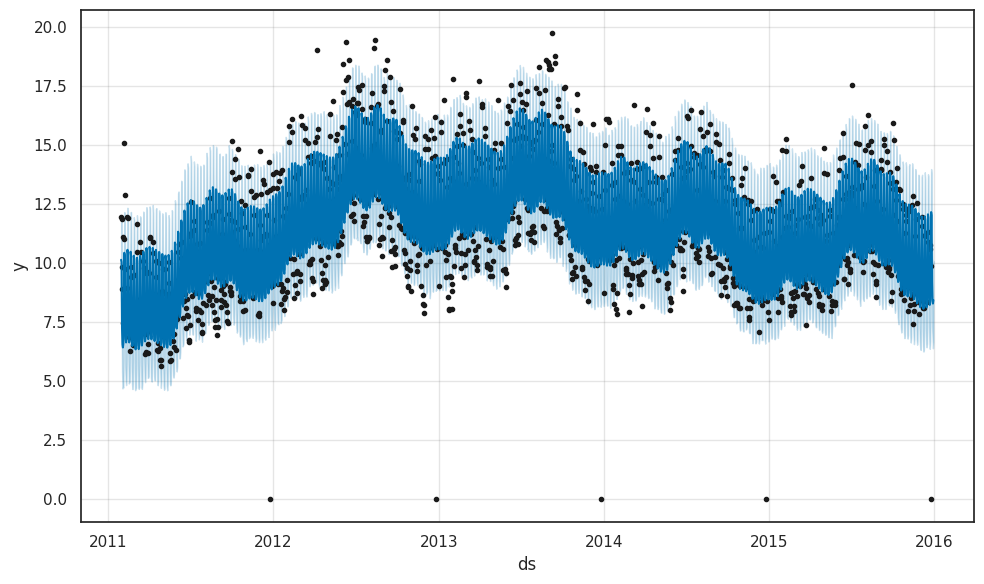

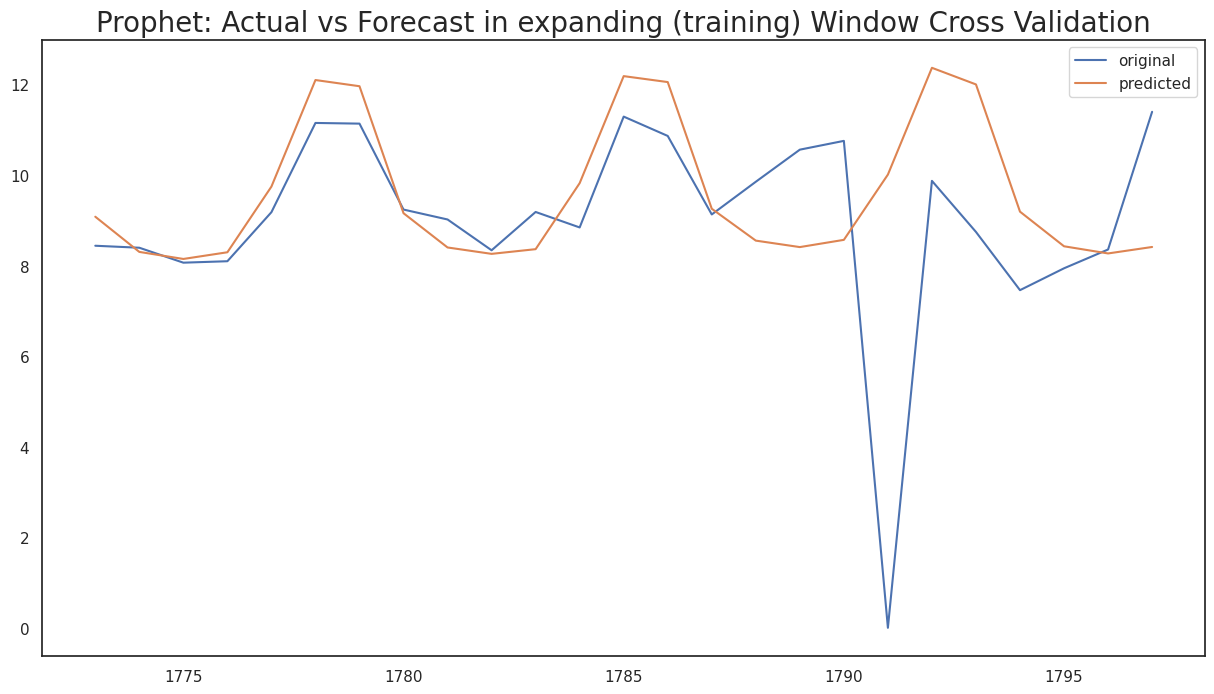

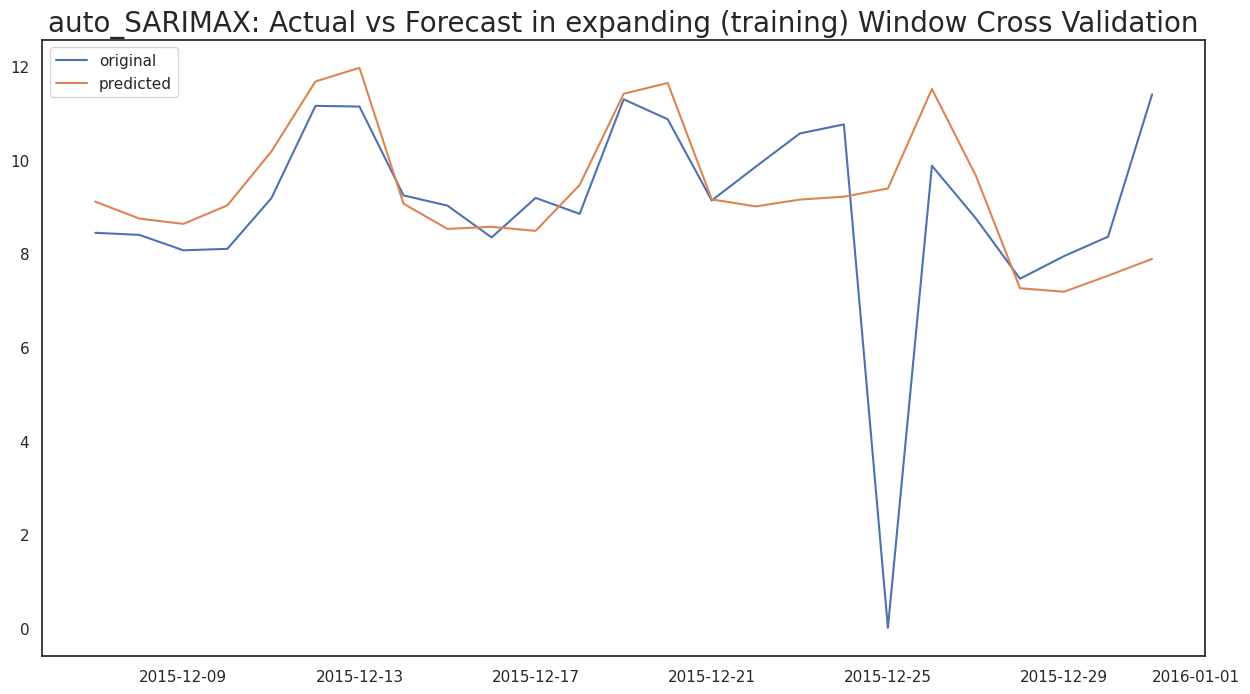

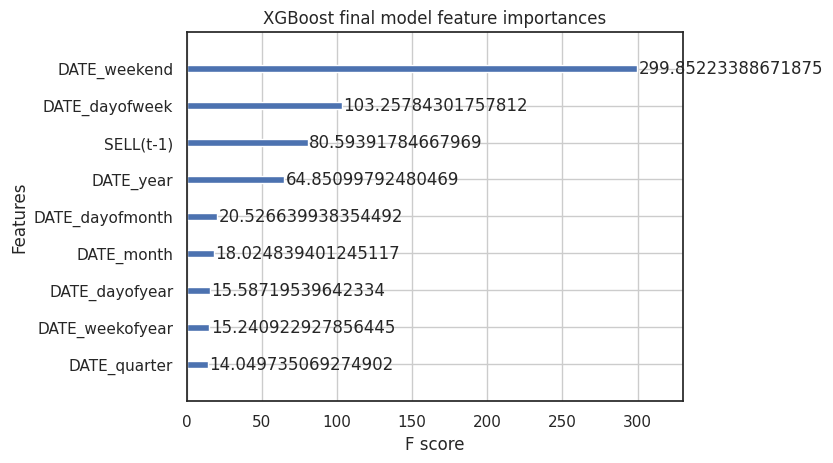

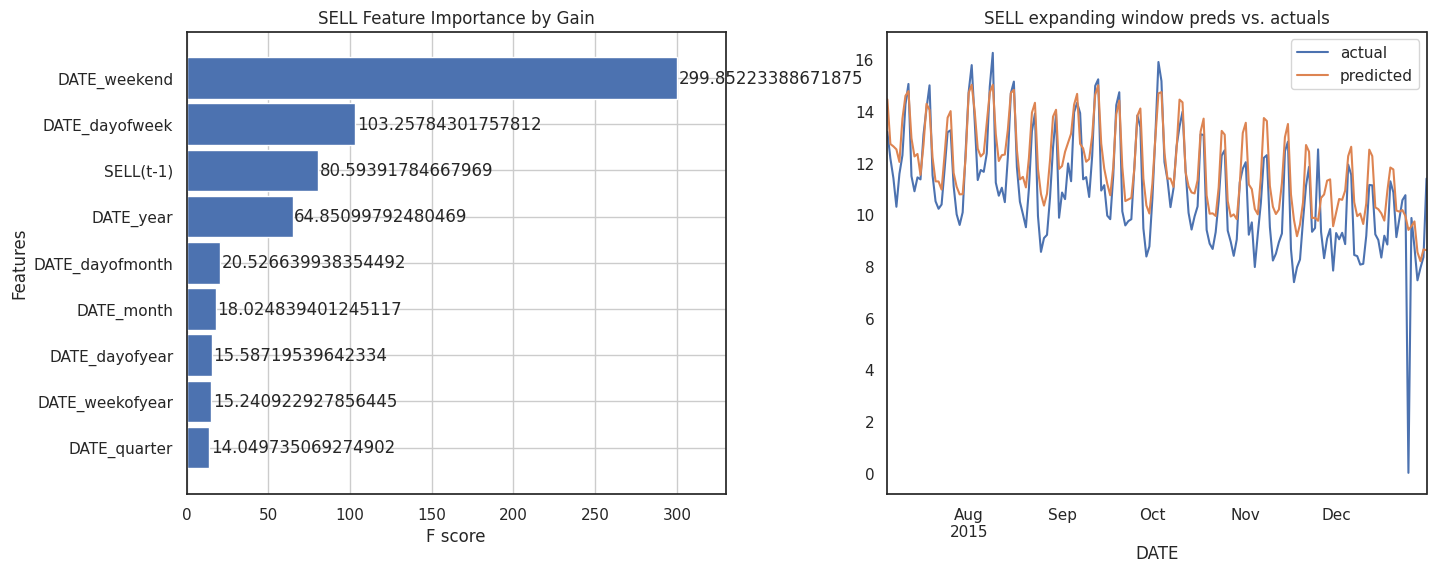

time: 23min 34s (started: 2024-05-08 06:48:58 +00:00)


In [ ]:
df_temp = df_sample.groupby("DATE")["SELL"].mean().reset_index()
y_train = df_temp[df_temp["DATE"].between("2011-01-01","2015-12-31")]
y_train = y_train[["DATE","SELL"]]

model_autots = auto_timeseries(
    score_type='rmse',
    time_interval='D',
    non_seasonal_pdq=None,
    seasonality=True,
    seasonal_period=7,
    model_type='best',
    conf_int = 0.95,
)
model_autots.fit(traindata= y_train, ts_column="DATE", target="SELL")

In [ ]:
y_test = pd.DataFrame(pd.date_range("2016-01-01", periods = 143), columns = ["DATE"])
y_test["DATE"] = pd.to_datetime(y_test["DATE"])

y_pred = model_autots.predict(y_test)

Predicting using test dataframe shape = (143, 1) for ML model
For large datasets: ML predictions will take time since it has to predict each row and use that for future predictions...
    Using given input: pandas dataframe...
    Alert: No strf_time_format given for DATE. Provide strf_time format during "setup" for better results.
ML predictions completed
time: 6.02 s (started: 2024-05-08 07:12:32 +00:00)


In [ ]:
df_result = df_sample.groupby("DATE")["SELL"].mean().reset_index()
df_result = df_result.merge(y_pred.reset_index(), on = "DATE", how = "left")

plot_performance(df_result, ground_truth = "SELL", predict_col_arr = ["yhat"])

SELL  vs  yhat
MAE 0.7157779505803034
RMSE 0.9349911219371747
MSE 0.8742083981013367
MAPE 0.06785932706585289
R2_score 0.7551904414105779


time: 189 ms (started: 2024-05-08 07:12:38 +00:00)


#### Vector AutoRegressive

In [ ]:
df_temp = df_sample.groupby("DATE")["SELL","SELL_PRICE"].mean().reset_index()
df_temp = df_temp.set_index("DATE").asfreq("D")

time: 142 ms (started: 2024-05-08 07:19:00 +00:00)


In [ ]:
model = VAR(df_temp)

time: 1.67 ms (started: 2024-05-08 07:19:00 +00:00)


In [ ]:
model.select_order(maxlags = 14).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

time: 157 ms (started: 2024-05-08 07:19:01 +00:00)


In [ ]:
model = model.fit(2)
model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 08, May, 2024
Time:                     07:19:14
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.1550
Nobs:                     1939.00    HQIC:                  -11.1732
Log likelihood:           5349.98    FPE:                1.38985e-05
AIC:                     -11.1837    Det(Omega_mle):     1.38271e-05
--------------------------------------------------------------------
Results for equation SELL
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.940420         1.152203           -0.816           0.414
L1.SELL               0.843540         0.022106           38.158           0.000
L1.SELL_PRICE         0.335486        19.769958            0.

time: 34.1 ms (started: 2024-05-08 07:19:14 +00:00)


In [ ]:
lag_order = model.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_temp.values[-lag_order:]
forecast_input

2


array([[13.183  ,  1.85714],
       [14.002  ,  1.85714]])

time: 18.2 ms (started: 2024-05-08 07:19:21 +00:00)


In [ ]:
fc = model.forecast(forecast_input, steps = 143)
df_forecast = pd.DataFrame(fc, index=df_temp.index[-143:], columns=df_temp.columns + '_VAR')
df_forecast = df_forecast.sort_index().reset_index()
df_forecast

DATE   SELL_VAR  SELL_PRICE_VAR
0   2016-01-01  13.399613        1.857085
1   2016-01-02  12.684539        1.857008
2   2016-01-03  12.233356        1.856947
3   2016-01-04  12.033189        1.856906
4   2016-01-05  11.978144        1.856877
..         ...        ...             ...
138 2016-05-18  12.000778        1.854108
139 2016-05-19  12.000637        1.854090
140 2016-05-20  12.000496        1.854072
141 2016-05-21  12.000355        1.854053
142 2016-05-22  12.000215        1.854035

[143 rows x 3 columns]

time: 39.5 ms (started: 2024-05-08 07:19:26 +00:00)


In [ ]:
df_result = df_sample.groupby("DATE")["SELL","SELL_PRICE"].mean().reset_index()
df_result = df_result.merge(df_forecast, on = "DATE", how = "left")

display(accuracy_check(df_result, ground_truth = "SELL", predict_col_arr = ["SELL_VAR"]))
plot_performance(df_result, ground_truth = "SELL", predict_col_arr = ["SELL_VAR"])

{'CATEGORY': 'overall',
 'Sum_actual': 22116.584,
 'Mean_actual': 11.394427614631633,
 'Std_actual': 2.5563699515959355,
 'Sum_predict_SELL_VAR': 1719.7336171449558,
 'Mean_predict_SELL_VAR': 0.8860039243405233,
 'MAE_SELL_VAR': 10.71284422931062,
 'RMSE_SELL_VAR': 11.283603245986038,
 'MAPE_SELL_VAR': 0.939636723711172}

SELL  vs  SELL_VAR
MAE 1.8688506929504782
RMSE 2.1120189825125335
MSE 4.4606241824932775
MAPE 0.18066350156213187
R2_score -0.2491340045704964


time: 105 ms (started: 2024-05-08 07:19:26 +00:00)


### Prophet
https://freedium.cfd/https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://towardsdatascience.com/demand-forecasting-using-fb-prophet-e3d1444b9dd8&ved=2ahUKEwiI8MTi8IuFAxW0yDgGHZZ4BD0QFnoECCIQAQ&sqi=2&usg=AOvVaw2TMevYwYADMycnpjlgCplY

https://forecastegy.com/posts/multiple-time-series-forecasting-with-prophet-in-python/

https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet


In [ ]:
df_result = pd.DataFrame()

for key, df_group in tqdm(df_sample.groupby("ID")):
    df_group = df_group[["ID","DATE", "SELL"]].sort_values("DATE").reset_index(drop = True)
    # df_group["PROPHET"] = np.nan
    df_group["ERROR_PROPHET"] = np.nan

    df_train = df_group[df_group["DATE"] < "2016-01-01"][["DATE","SELL"]]
    df_train.columns = ["ds","y"]
    # df_test = df_group[df_group["DATE"] >= "2016-01-01"][["DATE","exo_columns"]]
    # df_test.columns = ["ds","exo_columns"]
    try:
        model = Prophet(
            seasonality_mode = "additive",
            daily_seasonality = False,
            weekly_seasonality = True,
            yearly_seasonality = True,

        )
        # model.add_country_holidays(country_name = "US")
        # model.add_seasonality(name='monthly', period=30.5, fourier_order=2)
        # model.add_regressor('log_sell_price')
        model = model.fit(df_train)
        df_test = model.make_future_dataframe(143, include_history = False)
        df_pred = model.predict(df_test)
        df_pred = df_pred[["ds","yhat"]]
        df_group = df_group.merge(df_pred, left_on = "DATE", right_on = "ds", how = "left")
    except Exception as e:
        df_group["ERROR_PROPHET"] = str(e)

    df_result = pd.concat([df_result, df_group])

df_result = df_result.rename(columns = {"yhat" : "PROPHET"})

Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78745', 'data', 'file=/tmp/tmp331b9rbg/5di_ay20.json', 'init=/tmp/tmp331b9rbg/q0jt98ao.json', 'output', 'file=/tmp/tmp331b9rbg/prophet_modelok_bc9oc/prophet_model-20240508072245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:22:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:22:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
 24%|██▍       | 238/1000 [02:47<07:03,  1.80it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/nm3b_dl4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp331b9rbg/95vrwz0f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34994', 'data'

In [ ]:
display(df_result.head(3))
df_result.describe()

ID       DATE  SELL  ERROR_PROPHET  ds  PROPHET
0  FOODS_1_004_CA_1_evaluation 2011-01-29   0.0            NaN NaT      0.0
1  FOODS_1_004_CA_1_evaluation 2011-01-30   0.0            NaN NaT      0.0
2  FOODS_1_004_CA_1_evaluation 2011-01-31   0.0            NaN NaT      0.0

SELL  ERROR_PROPHET       PROPHET
count  1.941000e+06            0.0  1.941000e+06
mean   1.139443e+01            NaN  7.429453e-01
std    1.553195e+01            NaN  3.861341e+00
min    0.000000e+00            NaN -2.333390e+01
25%    2.000000e+00            NaN  0.000000e+00
50%    8.000000e+00            NaN  0.000000e+00
75%    1.500000e+01            NaN  0.000000e+00
max    7.630000e+02            NaN  1.405432e+02

time: 424 ms (started: 2024-05-08 07:42:27 +00:00)


In [ ]:
display(accuracy_check(df_result, ground_truth = "SELL", predict_col_arr = ["PROPHET"]))

# plot_temp = df_result[df_result["ID"] == "FOODS_1_218_TX_2_evaluation"]
plot_temp = df_result.groupby("DATE")["SELL","PROPHET"].mean().reset_index()
plot_performance(plot_temp, ground_truth = "SELL", predict_col_arr = ["PROPHET"])

{'CATEGORY': 'overall',
 'Sum_actual': 22116584.0,
 'Mean_actual': 11.394427614631633,
 'Std_actual': 15.531953863386246,
 'Sum_predict_PROPHET': 1442056.7765886188,
 'Mean_predict_PROPHET': 0.74294527387358,
 'MAE_PROPHET': 11.080000815649893,
 'RMSE_PROPHET': 18.91348778190045,
 'MAPE_PROPHET': 379662904423783.9}

SELL  vs  PROPHET
MAE 1.1207085773455576
RMSE 1.3601735488041333
MSE 1.8500720828664299
MAPE 0.09750880761114274
R2_score 0.4819137737079455


time: 547 ms (started: 2024-05-08 07:42:21 +00:00)


In [ ]:
df_total_result_model = df_total_result_model.merge(df_result, on = ["ID","DATE","SELL"], how = "left")
print(df_total_result_model.shape)
df_total_result_model.head(3)

(1941000, 12)


ID       DATE  SELL  ARIMA  ERROR_ARIMA  SARIMA  \
0  FOODS_1_004_CA_1_evaluation 2011-01-29   0.0    0.0          NaN     0.0   
1  FOODS_1_004_CA_1_evaluation 2011-01-30   0.0    0.0          NaN     0.0   
2  FOODS_1_004_CA_1_evaluation 2011-01-31   0.0    0.0          NaN     0.0   

   ERROR_SARIMA  ETS  ERROR_ETS  ERROR_PROPHET  ds  PROPHET  
0           NaN  0.0        NaN            NaN NaT      0.0  
1           NaN  0.0        NaN            NaN NaT      0.0  
2           NaN  0.0        NaN            NaN NaT      0.0

time: 2.01 s (started: 2024-05-08 07:43:12 +00:00)


### Greykite

https://freedium.cfd/https://towardsdatascience.com/linkedins-response-to-prophet-silverkite-and-greykite-4fd0131f64cb

Greykite contains a simple modeling interface that facilitates data exploration and model tuning. Its flagship algorithm, Silverkite, is highly customizable, with tuning parameters to capture diverse time series characteristics

In [ ]:
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results

time: 2.86 s (started: 2024-05-16 04:23:30 +00:00)


In [ ]:
df_temp = df_sample.groupby("DATE")["SELL"].mean().reset_index()
# Specifies dataset information
metadata = MetadataParam(
     time_col="DATE",  # name of the time column
     value_col="SELL",  # name of the value column
     freq="D"  #"MS" for Montly at start date, "H" for hourly, "D" for daily, "W" for weekly, etc.
)
# config model
config_forecast = ForecastConfig(
         model_template=ModelTemplateEnum.SILVERKITE.name,
         forecast_horizon=143,  # forecasts 100 steps ahead
         coverage=0.95,  # 95% prediction intervals
         metadata_param=metadata
)

# run model
forecaster = Forecaster()
result = forecaster.run_forecast_config(
     df=df_temp[df_temp["DATE"] < "2016-01-01"],
     config= config_forecast
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
time: 1min 22s (started: 2024-05-08 07:44:55 +00:00)


In [ ]:
result.forecast.plot()

time: 156 ms (started: 2024-05-08 07:46:18 +00:00)


In [ ]:
result.forecast.plot_components()

time: 436 ms (started: 2024-05-08 07:46:18 +00:00)


In [ ]:
from collections import defaultdict
backtest = result.backtest
backtest_eval = defaultdict(list)
for metric, value in backtest.train_evaluation.items():
    backtest_eval[metric].append(value)
    backtest_eval[metric].append(backtest.test_evaluation[metric])
metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
metrics

train        test
CORR                                                  0.949049    0.892649
R2                                                    0.900674     0.74378
MSE                                                   0.684247    1.167343
RMSE                                                  0.827192    1.080436
MAE                                                   0.631602    0.820084
MedAE                                                  0.51037    0.634811
MAPE                                                 31.666084   58.885707
MedAPE                                                4.426015    5.689007
sMAPE                                                  2.99712    4.546636
Q80                                                   0.315801    0.264256
Q95                                                   0.315801    0.191363
Q99                                                   0.315801    0.171924
OutsideTolerance1p                                    0.866465    0.846154
OutsideTolerance2p                                    0.758308    0.748252
OutsideTolerance3p                                    0.649547    0.692308
OutsideTolerance4p                                    0.545015    0.608392
OutsideTolerance5p                                     0.44713    0.538462
Outside Tolerance (fraction)                              None        None
R2_null_model_score                                       None        None
Prediction Band Width (%)                           115.973631  333.473027
Prediction Band Coverage (fraction)                    0.96435    0.909091
Coverage: Lower Band                                  0.489426    0.559441
Coverage: Upper Band                                  0.474924     0.34965
Coverage Diff: Actual_Coverage - Intended_Coverage     0.01435   -0.040909
MIS                                                   4.131597    4.941296

time: 23.3 ms (started: 2024-05-08 07:46:18 +00:00)


In [ ]:
summary = result.model[-1].summary()  # -1 retrieves the estimator from the pipeline
print(summary)

============================ Forecast Model Summary ============================

Number of observations: 1798,   Number of features: 290
Method: Ridge regression
Number of nonzero features: 290
Regularization parameter: 3.29

Residuals:
         Min           1Q       Median           3Q          Max
      -5.666      -0.6416     -0.05048        0.608        4.094

            Pred_col   Estimate Std. Err Pr(>)_boot sig. code                95%CI
           Intercept      8.951   0.2846     <2e-16       ***       (8.416, 9.538)
 events_C...New Year      0.203   0.3281      0.538              (-0.3533, 0.9064)
 events_C...w Year-1    -0.2786   0.2652      0.276              (-0.8118, 0.2852)
 events_C...w Year-2    0.01319   0.3131      0.962              (-0.5587, 0.6428)
 events_C...w Year+1     0.5391    0.273      0.046         *    (0.008113, 1.032)
 events_C...w Year+2     0.1729   0.2103      0.394              (-0.1889, 0.6161)
events_Christmas Day     -5.488     1.11     <2e-1

In [ ]:
model = result.model
model

Pipeline(steps=[('input',
                 PandasFeatureUnion(transformer_list=[('date',
                                                       Pipeline(steps=[('select_date',
                                                                        ColumnSelector(column_names=['ts']))])),
                                                      ('response',
                                                       Pipeline(steps=[('select_val',
                                                                        ColumnSelector(column_names=['y'])),
                                                                       ('outlier',
                                                                        DifferenceBasedOutlierTransformer()),
                                                                       ('null',
                                                                        NullTransformer(impute_algorithm='interpolate',
                                                                                        impute_params={'axis': 0,
                                                                                                       'lim...
                                                            'simple_freq': <SimpleTimeFrequencyEnum.DAY: Frequency(default_horizon=30, seconds_per_observation=86400, valid_seas={'YEARLY_SEASONALITY', 'QUARTERLY_SEASONALITY', 'MONTHLY_SEASONALITY', 'WEEKLY_SEASONALITY'})>,
                                                            'start_year': 2011},
                                           uncertainty_dict={'params': {'conditional_cols': ['dow_hr'],
                                                                        'quantile_estimation_method': 'normal_fit',
                                                                        'quantiles': [0.025000000000000022,
                                                                                      0.975],
                                                                        'sample_size_thresh': 5,
                                                                        'small_sample_size_method': 'std_quantiles',
                                                                        'small_sample_size_quantile': 0.98},
                                                             'uncertainty_method': 'simple_conditional_residuals'}))])

time: 150 ms (started: 2024-05-08 07:46:36 +00:00)


In [ ]:
df_future = result.timeseries.make_future_dataframe(
    periods = 143,
    include_history = False
)
df_future

ts   y
2016-01-01 2016-01-01 NaN
2016-01-02 2016-01-02 NaN
2016-01-03 2016-01-03 NaN
2016-01-04 2016-01-04 NaN
2016-01-05 2016-01-05 NaN
...               ...  ..
2016-05-18 2016-05-18 NaN
2016-05-19 2016-05-19 NaN
2016-05-20 2016-05-20 NaN
2016-05-21 2016-05-21 NaN
2016-05-22 2016-05-22 NaN

[143 rows x 2 columns]

time: 16 ms (started: 2024-05-08 07:46:36 +00:00)


In [ ]:
y_pred = model.predict(df_future)
y_pred

ts   forecast                          quantile_summary   err_std  \
0   2016-01-01   8.620322   (6.366961403940649, 10.873682040591039)  1.149695   
1   2016-01-02  12.947057  (10.615672128506782, 15.278441349474376)  1.189504   
2   2016-01-03  12.785953   (10.252467709037495, 15.31943731394159)  1.292618   
3   2016-01-04   9.835031    (7.760732361713609, 11.90932903393709)  1.058335   
4   2016-01-05   9.548863   (7.684917432408312, 11.412808268875025)  0.951010   
..         ...        ...                                       ...       ...   
138 2016-05-18   8.480921   (6.640023747055757, 10.321817556892892)  0.939250   
139 2016-05-19   8.885797   (6.9229924576893875, 10.84860134102099)  1.001449   
140 2016-05-20   9.468972   (7.240506069728257, 11.697438397223786)  1.136993   
141 2016-05-21  11.323865    (9.016822530102324, 13.63090753754193)  1.177084   
142 2016-05-22  11.456746   (8.949782982518279, 13.963708073669608)  1.279086   

     forecast_lower  forecast_upper  
0          6.366961       10.873682  
1         10.615672       15.278441  
2         10.252468       15.319437  
3          7.760732       11.909329  
4          7.684917       11.412808  
..              ...             ...  
138        6.640024       10.321818  
139        6.922992       10.848601  
140        7.240506       11.697438  
141        9.016823       13.630908  
142        8.949783       13.963708  

[143 rows x 6 columns]

time: 817 ms (started: 2024-05-08 07:46:36 +00:00)


In [ ]:
df_result = df_sample.groupby("DATE")["SELL"].mean().reset_index()
df_result = df_result.merge(y_pred, left_on = "DATE", right_on = "ts", how = "left")

time: 101 ms (started: 2024-05-08 07:46:37 +00:00)


In [ ]:
display(accuracy_check(df_result, ground_truth = "SELL", predict_col_arr = ["forecast", "forecast_upper", "forecast_lower"]))
plot_performance(df_result, ground_truth = "SELL", predict_col_arr = ["forecast", "forecast_upper" , "forecast_lower"])

{'CATEGORY': 'overall',
 'Sum_actual': 22116.584,
 'Mean_actual': 11.394427614631633,
 'Std_actual': 2.5563699515959355,
 'Sum_predict_forecast': 1478.4327613921234,
 'Mean_predict_forecast': 0.7616861212736339,
 'MAE_forecast': 10.649261461367635,
 'RMSE_forecast': 11.27392422660438,
 'MAPE_forecast': 0.9327006745293029,
 'Sum_predict_forecast_upper': 1780.8919066067679,
 'Mean_predict_forecast_upper': 0.9175125742435692,
 'MAE_forecast_upper': 10.676930135916262,
 'RMSE_forecast_upper': 11.277458502478598,
 'MAPE_forecast_upper': 0.9360769530030667,
 'Sum_predict_forecast_lower': 1175.9736161774788,
 'Mean_predict_forecast_lower': 0.6058596683036985,
 'MAE_forecast_lower': 10.788567946327934,
 'RMSE_forecast_lower': 11.299926189286234,
 'MAPE_forecast_lower': 0.9452431500872372}

SELL  vs  forecast
MAE 1.005814660941126
RMSE 1.223549567665949
MSE 1.4970735445355303
MAPE 0.0865175472823568
R2_score 0.5807659656328754
SELL  vs  forecast_upper
MAE 1.381373383310934
RMSE 1.6058996716459484
MSE 2.578913755392565
MAPE 0.1323452152374304
R2_score 0.2778120875193666
SELL  vs  forecast_lower
MAE 2.896681005751897
RMSE 3.0763926842455005
MSE 9.464191947679236
MAPE 0.25676191831697504
R2_score -1.6503115940649464


time: 80.1 ms (started: 2024-05-08 07:46:37 +00:00)


In [ ]:
temp_plot = df_result[df_result["DATE"] >= "2016-01-01"]

fig = go.Figure()
# add a transparent 'red' trace not visible on legend.
fig.add_trace(
    go.Scatter(
        x=temp_plot["DATE"],
        y=temp_plot["forecast"],
        fill=None,
        mode="lines",
        line_color="rgba(0,0,0,0)",
        showlegend=False,
    )
)
# add orange trace
fig.add_trace(
    go.Scatter(
        x=temp_plot["DATE"],
        y=temp_plot["forecast_upper"],
        fill="tonexty",
        mode="lines",
        line_color="orange",
        name = "upper_bound forecast",
    )
)
# re add the red trace, but visible this time, as this is the last one
fig.add_trace(
    go.Scatter(
        x=temp_plot["DATE"],
        y=temp_plot["forecast"],
        fill=None,
        mode="lines",
        line_color="red",
        name = "forecasted sell",
    )
)
# add the cyan trace
fig.add_trace(
    go.Scatter(
        x=temp_plot["DATE"],
        y=temp_plot["forecast_lower"],
        fill="tonexty",
        mode="lines",
        line_color="cyan",
        name = "lower_bound forecast",
    )
)
# finally add the black trace
fig.add_trace(
    go.Scatter(
        x=temp_plot["DATE"],
        y=temp_plot["SELL"],
        fill=None,
        mode="lines",
        line_color="black",
        name = "Actual Sell"
    )
)

time: 47.1 ms (started: 2024-05-08 07:46:37 +00:00)


In [ ]:
df_result = pd.DataFrame()

for key, df_group in tqdm(df_sample.groupby("ID")):
    df_group = df_group[["ID","DATE", "SELL"]].sort_values("DATE").reset_index(drop = True)
    # df_group["GREYKITE"] = np.nan
    df_group["ERROR_GREYKITE"] = np.nan

    df_train = df_group[df_group["DATE"] < "2016-01-01"][["DATE","SELL"]]
    # df_test = df_group[df_group["DATE"] >= "2016-01-01"][["DATE","exo_columns"]]
    try:
        # Specifies dataset information
        metadata = MetadataParam(
            time_col="DATE",  # name of the time column
            value_col="SELL",  # name of the value column
            freq="D"  #"MS" for Montly at start date, "H" for hourly, "D" for daily, "W" for weekly, etc.
        )
        # config model
        config_forecast = ForecastConfig(
                model_template=ModelTemplateEnum.SILVERKITE.name,
                forecast_horizon=143,  # forecasts 100 steps ahead
                coverage=0.95,  # 95% prediction intervals
                metadata_param=metadata
        )
        # run model
        forecaster = Forecaster()
        model_greykite = forecaster.run_forecast_config(
            df=df_train,
            config= config_forecast
        )

        df_future = model_greykite.timeseries.make_future_dataframe(
            periods = 143,
            include_history = False
        )
        df_pred = model_greykite.model.predict(df_future)
        df_group = df_group.merge(df_pred, left_on = "DATE", right_on = "ts", how = "left")
    except Exception as e:
        df_group["ERROR_GREYKITE"] = str(e)

    df_result = pd.concat([df_result, df_group])

df_result = df_result.rename(columns = {"forecast" : "GREYKITE"})

  0%|          | 0/1000 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|          | 1/1000 [00:42<11:53:04, 42.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|          | 2/1000 [01:36<13:37:38, 49.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|          | 3/1000 [02:23<13:17:23, 47.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|          | 4/1000 [03:28<15:11:00, 54.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|          | 5/1000 [04:11<13:56:56, 50.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  1%|          | 6/1000 [05:06<14:24:40, 52.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  1%|          | 7/1000 [05:58<14:19:28, 51.93s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  1%|          | 8/1000 [07:06<15:46:14, 57.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  1%|          | 9/1000 [07:49<14:30:07, 52.68s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  1%|          | 10/1000 [08:33<13:45:31, 50.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  1%|          | 11/1000 [09:22<13:37:51, 49.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  1%|          | 12/1000 [10:11<13:35:54, 49.55s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  1%|▏         | 13/1000 [11:07<14:09:42, 51.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  1%|▏         | 14/1000 [12:01<14:18:39, 52.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  2%|▏         | 15/1000 [12:51<14:06:24, 51.56s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  2%|▏         | 16/1000 [13:42<14:02:57, 51.40s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  2%|▏         | 17/1000 [14:36<14:13:27, 52.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  2%|▏         | 18/1000 [15:19<13:28:48, 49.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  2%|▏         | 19/1000 [16:14<13:53:12, 50.96s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  2%|▏         | 20/1000 [16:53<12:57:14, 47.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  2%|▏         | 21/1000 [17:36<12:33:51, 46.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  2%|▏         | 22/1000 [18:24<12:42:36, 46.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  2%|▏         | 23/1000 [19:13<12:52:19, 47.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  2%|▏         | 24/1000 [19:59<12:42:51, 46.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  2%|▎         | 25/1000 [20:48<12:50:58, 47.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|▎         | 26/1000 [21:35<12:51:00, 47.50s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|▎         | 27/1000 [22:20<12:37:04, 46.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|▎         | 28/1000 [23:08<12:39:53, 46.91s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|▎         | 29/1000 [23:52<12:25:13, 46.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
display(df_result.head(3))
df_result.describe()

In [ ]:
display(accuracy_check(df_result, ground_truth = "SELL", predict_col_arr = ["GREYKITE"]))

# plot_temp = df_result[df_result["ID"] == "FOODS_1_218_TX_2_evaluation"]
plot_temp = df_result.groupby("DATE")["SELL","GREYKITE"].mean().reset_index()
plot_performance(plot_temp, ground_truth = "SELL", predict_col_arr = ["GREYKITE"])

In [ ]:
df_total_result_model = df_total_result_model.merge(df_result, on = ["ID","DATE","SELL"], how = "left")
print(df_total_result_model.shape)
df_total_result_model.head(3)

ID       DATE  SELL  ARIMA  ERROR_ARIMA  ETS  \
0  FOODS_1_218_TX_2_evaluation 2011-01-29   5.0    0.0          NaN  0.0   
1  FOODS_1_218_TX_2_evaluation 2011-01-30   3.0    0.0          NaN  0.0   
2  FOODS_1_218_TX_2_evaluation 2011-01-31   2.0    0.0          NaN  0.0   

   ERROR_ETS  
0        NaN  
1        NaN  
2        NaN

time: 30.9 ms (started: 2024-03-23 10:48:14 +00:00)


### Machine Learning

Experiment direct multi-step forecasting

https://freedium.cfd/https://towardsdatascience.com/improve-time-series-forecasting-performance-with-facebook-prophet-model-f7e83ffab6a3

https://freedium.cfd/https://towardsdatascience.com/a-step-by-step-guide-to-feature-engineering-for-multivariate-time-series-162ccf232e2f

In [ ]:
df_model = df_sample.copy()

df_model = df_model.merge(df_ts_feature_total, on = ["ID","DATE","SELL"], how = "left")
df_model = df_model.fillna(0)

df_model = df_model.merge(df_trendline_feature, on = ["ID","DATE"], how = "left")

df_model["DAY_WEEK_COUNT"] = df_model.groupby(["ID","YEARWEEK"])["DATE"].transform("count").astype(int)
df_model = df_model.merge(df_phasing_features, on = ["ID","DATE","YEARWEEK","SELL","DAY_WEEK_COUNT","DAY_OF_WEEK"], how = "left")

# df_model = df_model.merge(df_change_point, on = ["ID","DATE"], how = "left")

df_model = downcast(df_model)

time: 39.5 s (started: 2024-06-24 14:22:23 +00:00)


In [ ]:
X_train = df_model[df_model["DATE"] < "2016-01-01"].drop(["SELL","DATE"], axis = 1)
Y_train = df_model[df_model["DATE"] < "2016-01-01"]["SELL"]


X_test = df_model[df_model["DATE"] >= "2016-01-01"].drop(["SELL","DATE"], axis = 1)
Y_test = df_model[df_model["DATE"] >= "2016-01-01"]["SELL"]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1798000, 97), (143000, 97), (1798000,), (143000,))

time: 4.54 s (started: 2024-06-24 14:26:00 +00:00)


In [ ]:
categorical_cols = [feature for feature in X_train.columns if X_train[feature].dtype == "O"]
for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")
categorical_cols

[]

time: 9.31 ms (started: 2024-06-24 14:28:41 +00:00)


In [ ]:
# model = XGBRegressor(enable_categorical = True)
model = LGBMRegressor(categorical_features = categorical_cols)
model.fit(X_train, Y_train)

# model.booster_.save_model('/content/drive/MyDrive/Capstone project m5 forecast/LGBM_model.txt')

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with categorical_column=0,1,2,3,4,5,8,12,13,14,15, categorical_features= will be ignored. Current value: categorical_feature=0,1,2,3,4,5,8,12,13,14,15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.113816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11370
[LightGBM] [Info] Number of data points in the train set: 1798000, number of used features: 93
[LightGBM] [Info] Start training from score 11.416232


LGBMRegressor(categorical_features=[])

time: 34.4 s (started: 2024-06-24 14:28:46 +00:00)


In [ ]:
Y_pred = model.predict(X_test)
df_eval = X_test.copy()
df_eval["DATE"] = pd.to_datetime(
    df_eval["YEAR"].astype(str) + "-" +
    df_eval["MONTH"].astype(str) + "-" +
    df_eval["DAY_OF_MONTH"].astype(str),
    format = "%Y-%m-%d"
)
df_eval["ACTUAL"] = Y_test.astype(float)
df_eval["PREDICT"] = Y_pred.astype(float)
df_eval[["ACTUAL","PREDICT","DATE"]].describe()

ACTUAL        PREDICT
count  143000.000000  143000.000000
mean       11.120273      10.324203
std        13.000131       9.091214
min         0.000000      -4.293794
25%         3.000000       5.569675
50%         8.000000       7.801190
75%        14.000000      12.012490
max       248.000000     137.307589

time: 318 ms (started: 2024-06-24 14:41:49 +00:00)


In [ ]:
display(accuracy_check(df_eval, ground_truth = "ACTUAL", predict_col_arr = ["PREDICT"]))

# plot_temp = df_eval[df_eval["ID"] == "FOODS_1_218_TX_2_evaluation"]
plot_temp = df_eval.groupby("DATE")["ACTUAL","PREDICT"].mean().reset_index()
plot_performance(plot_temp, ground_truth = "ACTUAL", predict_col_arr = ["PREDICT"])

{'CATEGORY': 'overall',
 'Sum_actual': 1590199.0,
 'Mean_actual': 11.120272727272727,
 'Std_actual': 13.000131100138375,
 'Sum_predict_PREDICT': 1509369.7862288514,
 'Mean_predict_PREDICT': 10.555033470131828,
 'MAE_PREDICT': 6.022728359796447,
 'RMSE_PREDICT': 9.151397750157143,
 'MAPE_PREDICT': 5220785488526621.0}

ACTUAL  vs  PREDICT
MAE 0.7813092224460774
RMSE 0.9946664626636557
MSE 0.9893613719478296
MAPE 0.06762150673959282
R2_score 0.7229434980514826


time: 185 ms (started: 2024-05-09 08:34:52 +00:00)


### Post model EDA

In [ ]:
pd.DataFrame.from_dict(
    [
        accuracy_check(df_total_result_model, ground_truth = "SELL", predict_col_arr = ["ARIMA","ETS","PROPHET","ML_LGBM"])
    ]
)

CATEGORY  Sum_actual  Mean_actual  Std_actual  Sum_predict_ARIMA  \
0  overall  22116584.0    11.394428   15.531954       1.325985e+06   

   Mean_predict_ARIMA  MAE_ARIMA  RMSE_ARIMA    MAPE_ARIMA  Sum_predict_ETS  \
0            0.683145  11.070601   18.959107  2.426347e+14     1.389151e+06   

   ...  Sum_predict_PROPHET  Mean_predict_PROPHET  MAE_PROPHET  RMSE_PROPHET  \
0  ...         1.442057e+06              0.742945    11.080001     18.913488   

   MAPE_PROPHET  Sum_predict_ML_LGBM  Mean_predict_ML_LGBM  MAE_ML_LGBM  \
0  3.796629e+14         1.509370e+06              0.777625    11.018874   

   RMSE_ML_LGBM  MAPE_ML_LGBM  
0      18.85956  3.846328e+14  

[1 rows x 24 columns]

time: 1.03 s (started: 2024-05-09 09:07:51 +00:00)


In [ ]:
pd.DataFrame.from_dict(
    [
        accuracy_check(df_group, key = key, ground_truth = "ACTUAL", predict_col_arr = ["PREDICT"])
        for key, df_group in df_eval.groupby("STATE")
    ]
)

CATEGORY  Sum_actual  Mean_actual  Std_actual  Sum_predict_PREDICT  \
0       CA    663187.0    10.468784   12.055976        669693.420728   
1       TX    446165.0    10.505168   12.831289        438476.314163   
2       WI    480847.0    12.932948   14.486595        401200.051338   

   Mean_predict_PREDICT  MAE_PREDICT  RMSE_PREDICT  MAPE_PREDICT  
0             10.571492     5.614517      8.302522  4.715102e+15  
1             10.324134     5.461100      7.829705  5.140040e+15  
2             10.790749     7.359811     11.603032  6.174629e+15

time: 445 ms (started: 2024-05-09 09:16:04 +00:00)


In [ ]:
def wmape_custom(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    bias = np.sum(np.abs(y_true - y_pred))
    # bias = np.abs(np.sum(y_true) - np.sum(y_pred))
    wmape = bias / np.sum(y_true)
    return wmape

for col in ["ARIMA","ETS","PROPHET","ML_LGBM"]:
    df_eval_temp = df_total_result_model[df_total_result_model["DATE"] >= "2016-1-1"]
    print(col, wmape_custom(df_eval_temp["SELL"], df_eval_temp[col]))

ARIMA 0.7252351883132461
ETS 0.7180028699241433
PROPHET 0.6795131780417883
ML_LGBM 0.5706024880773045
time: 112 ms (started: 2024-07-27 12:02:48 +00:00)


In [ ]:
display(accuracy_check(
    df_total_result_model[df_total_result_model["DATE"] >= "2016-1-1"],
    ground_truth = "SELL",
    predict_col_arr = ["ARIMA","ETS","PROPHET","ML_LGBM"]
))

{'CATEGORY': 'overall',
 'Sum_actual': 1590199.0,
 'Mean_actual': 11.120272727272727,
 'Std_actual': 13.000131100138375,
 'Sum_predict_ARIMA': 1325984.8952888362,
 'Mean_predict_ARIMA': 9.272621645376477,
 'MAE_ARIMA': 6.724831505142091,
 'RMSE_ARIMA': 11.612423611997446,
 'MAPE_ARIMA': 3293384542351130.0,
 'Sum_predict_ETS': 1389151.4561169315,
 'Mean_predict_ETS': 9.714345846971549,
 'MAE_ETS': 6.974928197561255,
 'RMSE_ETS': 12.178786515771854,
 'MAPE_ETS': 3683026298764482.5,
 'Sum_predict_PROPHET': 1442056.7765886185,
 'Mean_predict_PROPHET': 10.084313122997333,
 'MAE_PROPHET': 6.852423658576429,
 'RMSE_PROPHET': 10.554494607394412,
 'MAPE_PROPHET': 5153326555850093.0,
 'Sum_predict_ML_LGBM': 1509369.7862288514,
 'Mean_predict_ML_LGBM': 10.555033470131828,
 'MAE_ML_LGBM': 6.022728359796447,
 'RMSE_ML_LGBM': 9.151397750157143,
 'MAPE_ML_LGBM': 5220785488526621.0}

time: 208 ms (started: 2024-05-14 09:07:33 +00:00)


In [ ]:
plot_temp = df_total_result_model.groupby("DATE")["SELL","ARIMA","ETS","PROPHET","ML_LGBM"].mean().reset_index()
plot_performance(plot_temp, ground_truth = "SELL", predict_col_arr = ["ARIMA","ETS","PROPHET","ML_LGBM"])

SELL  vs  ARIMA
MAE 2.0318422854759204
RMSE 2.647830192627259
MSE 7.011004728988508
MAPE 0.1645331145096146
R2_score -0.9633315999934726
SELL  vs  ETS
MAE 1.4773827461236888
RMSE 1.714397035796935
MSE 2.939157196349317
MAPE 0.12782321830912893
R2_score 0.1769310642337334
SELL  vs  PROPHET
MAE 1.1207085773455576
RMSE 1.360173548804133
MSE 1.8500720828664294
MAPE 0.09750880761114272
R2_score 0.48191377370794564
SELL  vs  ML_LGBM
MAE 0.7813092224460774
RMSE 0.9946664626636557
MSE 0.9893613719478296
MAPE 0.06762150673959282
R2_score 0.7229434980514826


time: 614 ms (started: 2024-05-09 08:40:17 +00:00)


In [ ]:
pd.set_option('display.max_rows', None)
display(df_model.corr()["SELL"].sort_values(ascending = False))
pd.set_option('display.max_rows', 10)

SELL                              1.000000
TRENDLINE_DAILY                   0.618839
SELL_WAVELET                      0.222120
IS_WEEKEND                        0.095161
DAY_OF_WEEK                       0.080403
total_lag_143_moving_min_14       0.069271
total_lag_143_moving_min_30       0.068416
total_lag_150_moving_min_14       0.067952
total_lag_143_moving_min_7        0.066478
total_lag_150_moving_min_30       0.065956
total_lag_150_moving_min_7        0.064722
total_lag_143_moving_min_60       0.056542
total_lag_143_moving_median_14    0.053968
total_lag_150_moving_min_60       0.053337
total_lag_150_moving_median_7     0.052693
total_lag_143_moving_median_7     0.052573
total_lag_150_moving_median_14    0.052508
total_lag_143_moving_mean_14      0.052251
total_lag_143_moving_mean_7       0.051339
total_lag_150_moving_mean_7       0.051079
total_lag_150_moving_mean_14      0.050796
total_lag_143_moving_median_30    0.050482
total_lag_143_moving_mean_30      0.049812
total_lag_1

time: 56.3 s (started: 2024-05-09 08:51:07 +00:00)


In [ ]:
f_importance = pd.DataFrame({'Feature_Name': X_test.columns, 'Weight_Importance': model.feature_importances_})\
               .sort_values("Weight_Importance", ascending = False).reset_index(drop = True)
pd.set_option('display.max_rows', None)
display(f_importance)
pd.set_option('display.max_rows', 10)

Feature_Name  Weight_Importance
0                               ID               1113
1                         YEARWEEK                423
2                       SELL_PRICE                242
3                             ITEM                241
4                  TRENDLINE_DAILY                209
5                      DAY_OF_YEAR                178
6                     SELL_WAVELET                158
7                      DAY_OF_WEEK                151
8                     EVENT_NAME_1                 58
9                   DAY_OF_QUARTER                 45
10                    DAY_OF_MONTH                 42
11                            YEAR                 28
12                           MONTH                 23
13                        WEEK_DAY                 21
14                           STATE                 10
15                         SNAP_WI                 10
16                           STORE                  9
17                   IS_YEAR_START                  6
18                         SNAP_TX                  6
19                   WEEK_OF_MONTH                  5
20                 WEEK_OF_QUARTER                  5
21                      IS_WEEKEND                  4
22    total_lag_150_moving_mean_14                  2
23  total_lag_143_moving_median_30                  1
24     total_lag_143_moving_mean_7                  1
25     total_lag_150_moving_max_14                  1
26                         SNAP_CA                  1
27      total_lag_143_moving_max_7                  1
28     total_lag_143_moving_min_14                  1
29    total_lag_143_moving_mean_30                  1
30     total_lag_150_moving_min_14                  1
31     total_lag_143_moving_max_30                  1
32    total_lag_143_moving_mean_60                  1
33     total_lag_143_moving_std_60                  1
34  total_lag_150_moving_median_14                  0
35      total_lag_150_moving_std_7                  0
36      total_lag_150_moving_min_7                  0
37                    RATIO_MEDIAN                  0
38      total_lag_150_moving_max_7                  0
39     total_lag_150_moving_std_14                  0
40     total_lag_150_moving_mean_7                  0
41     total_lag_143_moving_max_90                  0
42     total_lag_143_moving_min_90                  0
43   total_lag_150_moving_median_7                  0
44    total_lag_150_moving_mean_30                  0
45     total_lag_150_moving_std_30                  0
46  total_lag_150_moving_median_30                  0
47     total_lag_150_moving_min_90                  0
48     total_lag_150_moving_max_90                  0
49                  DAY_WEEK_COUNT                  0
50                      RATIO_MEAN                  0
51  total_lag_150_moving_median_90                  0
52     total_lag_150_moving_std_90                  0
53    total_lag_150_moving_mean_90                  0
54     total_lag_150_moving_max_60                  0
55     total_lag_143_moving_std_90                  0
56     total_lag_150_moving_min_60                  0
57  total_lag_150_moving_median_60                  0
58     total_lag_150_moving_std_60                  0
59    total_lag_150_moving_mean_60                  0
60     total_lag_150_moving_max_30                  0
61     total_lag_150_moving_min_30                  0
62  total_lag_143_moving_median_90                  0
63  total_lag_143_moving_median_14                  0
64    total_lag_143_moving_mean_90                  0
65                  IS_MONTH_START                  0
66                   total_lag_144                  0
67                   total_lag_143                  0
68                     IS_YEAR_END                  0
69                  IS_QUARTER_END                  0
70                IS_QUARTER_START                  0
71                    IS_MONTH_END                  0
72                         QUARTER                  0
73     total_lag_143_movin

time: 21.7 ms (started: 2024-05-09 08:42:28 +00:00)


In [ ]:
df_result = df_eval[["ID","DATE","ACTUAL","PREDICT"]].copy()
df_result.columns = ["ID","DATE","SELL","ML_LGBM"]
df_result.describe(include = "all")

ID                 DATE           SELL  \
count                        143000               143000  143000.000000   
unique                         1000                  143            NaN   
top     FOODS_1_004_CA_1_evaluation  2016-01-01 00:00:00            NaN   
freq                            143                 1000            NaN   
first                           NaN  2016-01-01 00:00:00            NaN   
last                            NaN  2016-05-22 00:00:00            NaN   
mean                            NaN                  NaN      11.120273   
std                             NaN                  NaN      13.000131   
min                             NaN                  NaN       0.000000   
25%                             NaN                  NaN       3.000000   
50%                             NaN                  NaN       8.000000   
75%                             NaN                  NaN      14.000000   
max                             NaN                  NaN     248.000000   

              ML_LGBM  
count   143000.000000  
unique            NaN  
top               NaN  
freq              NaN  
first             NaN  
last              NaN  
mean        10.555033  
std          9.341399  
min        -10.637360  
25%          5.748680  
50%          8.029242  
75%         12.103536  
max        140.522574

time: 165 ms (started: 2024-05-09 08:38:13 +00:00)


In [ ]:
df_total_result_model = df_total_result_model.merge(df_result, on = ["ID","DATE","SELL"], how = "left")
print(df_total_result_model.shape)
df_total_result_model.head(3)

(1941000, 12)


ID       DATE  SELL  ARIMA  ERROR_ARIMA  SARIMA  \
0  FOODS_1_004_CA_1_evaluation 2011-01-29   0.0    0.0          NaN     0.0   
1  FOODS_1_004_CA_1_evaluation 2011-01-30   0.0    0.0          NaN     0.0   
2  FOODS_1_004_CA_1_evaluation 2011-01-31   0.0    0.0          NaN     0.0   

   ERROR_SARIMA  ETS  ERROR_ETS  ERROR_PROPHET  PROPHET  ML_LGBM  
0           NaN  0.0        NaN            NaN      0.0      NaN  
1           NaN  0.0        NaN            NaN      0.0      NaN  
2           NaN  0.0        NaN            NaN      0.0      NaN

time: 2.75 s (started: 2024-05-09 08:38:27 +00:00)


### Deep learning

Experiment multi-output forecasting

In [ ]:
MAX_EPOCHS = 20
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

#### Single step models

In [ ]:
performance = {}
val_performance = {}

CNN model

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(6,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
history = compile_and_fit(conv_model , window_df)

Epoch 1/20
45/45 [==============================] - 2s 12ms/step - loss: 1.4039 - mean_absolute_error: 0.8933 - val_loss: 47.6836 - val_mean_absolute_error: 4.6806
Epoch 2/20
45/45 [==============================] - 0s 7ms/step - loss: 1.4734 - mean_absolute_error: 0.8302 - val_loss: 23.3133 - val_mean_absolute_error: 3.1778
Epoch 3/20
45/45 [==============================] - 0s 6ms/step - loss: 1.0907 - mean_absolute_error: 0.7148 - val_loss: 140.4342 - val_mean_absolute_error: 9.8857
Epoch 4/20
45/45 [==============================] - 0s 7ms/step - loss: 1.1210 - mean_absolute_error: 0.6918 - val_loss: 24.2981 - val_mean_absolute_error: 3.4907


In [ ]:
performance["CNN_model"] = conv_model.evaluate(window_df.test , return_dict = True)
val_performance["CNN_model"] = conv_model.evaluate(window_df.val , return_dict = True)

12/12 [==============================] - 0s 10ms/step - loss: 24.2981 - mean_absolute_error: 3.4907


LSTM

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model , window_df)

Epoch 1/20
45/45 [==============================] - 3s 23ms/step - loss: 1.4082 - mean_absolute_error: 0.8768 - val_loss: 0.4297 - val_mean_absolute_error: 0.5250
Epoch 2/20
45/45 [==============================] - 0s 10ms/step - loss: 0.7887 - mean_absolute_error: 0.6567 - val_loss: 0.3082 - val_mean_absolute_error: 0.4299
Epoch 3/20
45/45 [==============================] - 1s 14ms/step - loss: 0.5331 - mean_absolute_error: 0.5393 - val_loss: 0.2368 - val_mean_absolute_error: 0.3924
Epoch 4/20
45/45 [==============================] - 1s 17ms/step - loss: 0.3684 - mean_absolute_error: 0.4283 - val_loss: 0.2462 - val_mean_absolute_error: 0.4001
Epoch 5/20
45/45 [==============================] - 1s 18ms/step - loss: 0.3283 - mean_absolute_error: 0.4084 - val_loss: 0.2399 - val_mean_absolute_error: 0.3979


In [ ]:
performance["lstm_model"] = lstm_model.evaluate(window_df.test , return_dict = True)
val_performance["lstm_model"] = lstm_model.evaluate(window_df.val , return_dict = True)

12/12 [==============================] - 0s 8ms/step - loss: 0.2399 - mean_absolute_error: 0.3979


In [ ]:
def compare_model(performance , val_performance):
  x = np.arange(len(performance))
  width = 0.3
  metric_name = 'mean_absolute_error'
  val_mae = [v[metric_name] for v in val_performance.values()]
  test_mae = [v[metric_name] for v in performance.values()]

  plt.ylabel('mean_absolute_error [T (degC), normalized]')
  plt.bar(x - 0.17, val_mae, width, label='Validation')
  plt.bar(x + 0.17, test_mae, width, label='Test')
  plt.xticks(ticks=x, labels=performance.keys(),
            rotation=45)
  _ = plt.legend()

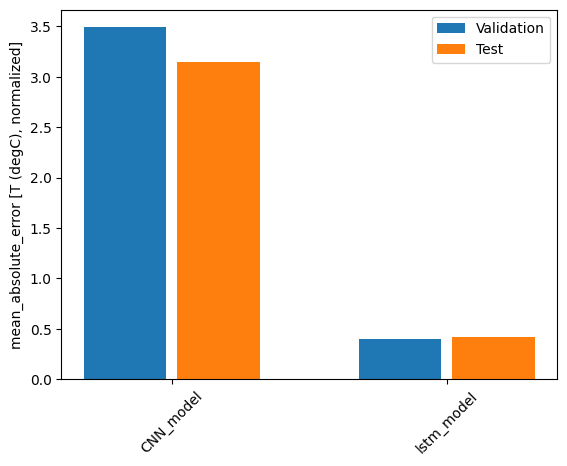

In [ ]:
compare_model(performance , val_performance)

#### Multi-Step

In [ ]:
INPUT_WIDTH = 20
OUT_STEPS = 15
mul_window = WindowGenerator(input_width = INPUT_WIDTH, label_width = OUT_STEPS, shift = OUT_STEPS,
               train_df =df_train, val_df = df_val, test_df= df_test, label_columns=["SELL"])

In [ ]:
mul_window.train.take(1).element_spec

(TensorSpec(shape=(None, 20, 94), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 15, 1), dtype=tf.float32, name=None))

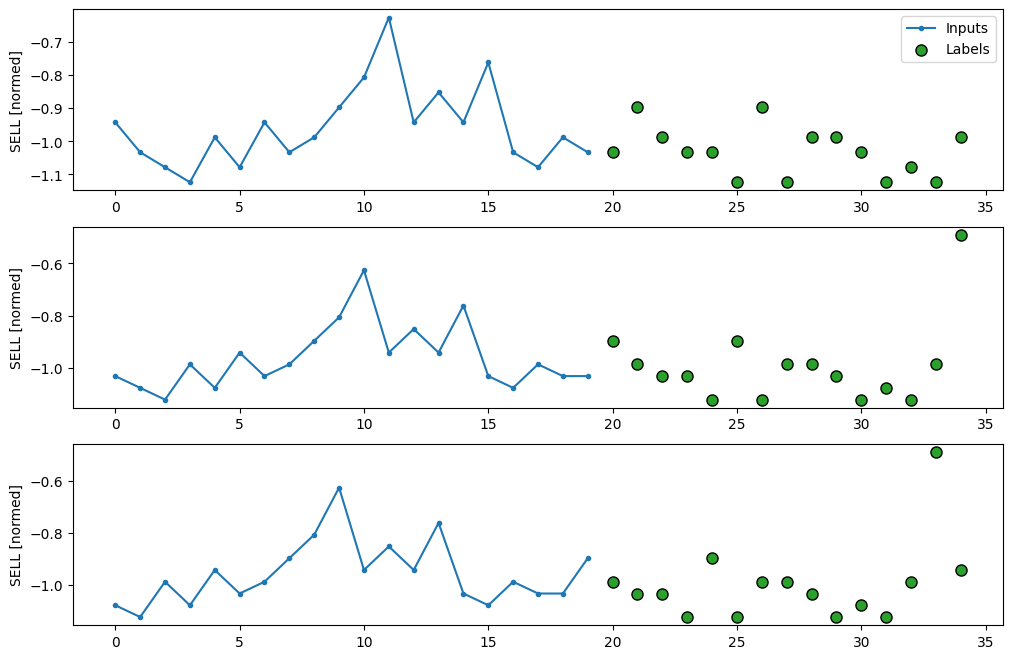

In [ ]:
mul_window.plot()

In [ ]:
performance_mul_step = {}
val_performance_mul_step = {}

In [ ]:
mul_conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(3,),
                           activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units= 68 , activation = 'relu'),
    tf.keras.layers.Dense(units= OUT_STEPS),
    tf.keras.layers.Reshape([OUT_STEPS , 1])
])

In [ ]:
history = compile_and_fit(mul_conv_model , mul_window)

Epoch 1/20
44/44 [==============================] - 1s 12ms/step - loss: 1.6106 - mean_absolute_error: 0.9457 - val_loss: 23.5112 - val_mean_absolute_error: 3.7332
Epoch 2/20
44/44 [==============================] - 0s 9ms/step - loss: 1.0213 - mean_absolute_error: 0.7694 - val_loss: 2.4672 - val_mean_absolute_error: 1.1064
Epoch 3/20
44/44 [==============================] - 0s 9ms/step - loss: 0.9393 - mean_absolute_error: 0.7388 - val_loss: 1.9313 - val_mean_absolute_error: 0.9680
Epoch 4/20
44/44 [==============================] - 0s 9ms/step - loss: 0.8170 - mean_absolute_error: 0.6959 - val_loss: 2.2893 - val_mean_absolute_error: 1.0298
Epoch 5/20
44/44 [==============================] - 0s 9ms/step - loss: 0.6768 - mean_absolute_error: 0.6320 - val_loss: 1.8413 - val_mean_absolute_error: 0.9443
Epoch 6/20
44/44 [==============================] - 1s 12ms/step - loss: 0.5947 - mean_absolute_error: 0.5909 - val_loss: 2.1399 - val_mean_absolute_error: 0.9882
Epoch 7/20
44/44 [=======

In [ ]:
performance_mul_step["mul_conv_model"] = mul_conv_model.evaluate(mul_window.test , return_dict = True)
val_performance_mul_step["mul_conv_model"] =  mul_conv_model.evaluate(mul_window.val , return_dict = True)

11/11 [==============================] - 0s 7ms/step - loss: 2.6141 - mean_absolute_error: 1.0856


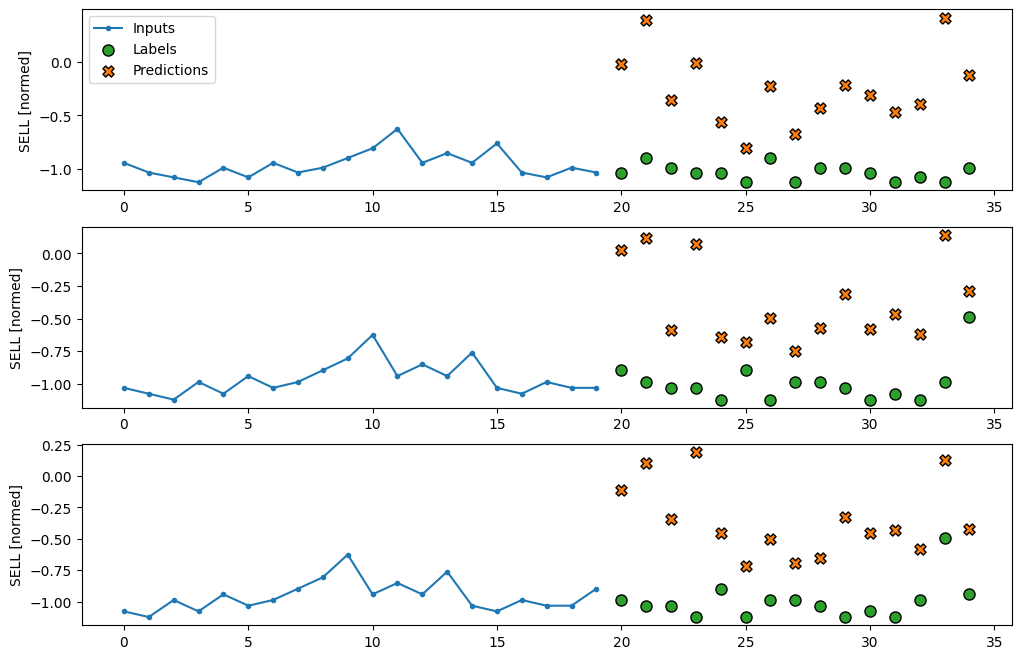

In [ ]:
mul_window.plot(mul_conv_model)

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS,
                          ),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS,1])
])

In [ ]:
history = compile_and_fit(multi_lstm_model , mul_window)

Epoch 1/20
44/44 [==============================] - 5s 49ms/step - loss: 1.0304 - mean_absolute_error: 0.7715 - val_loss: 0.4176 - val_mean_absolute_error: 0.5367
Epoch 2/20
44/44 [==============================] - 1s 18ms/step - loss: 0.8993 - mean_absolute_error: 0.7209 - val_loss: 0.3861 - val_mean_absolute_error: 0.5137
Epoch 3/20
44/44 [==============================] - 1s 31ms/step - loss: 0.7763 - mean_absolute_error: 0.6676 - val_loss: 0.3434 - val_mean_absolute_error: 0.4825
Epoch 4/20
44/44 [==============================] - 2s 39ms/step - loss: 0.6472 - mean_absolute_error: 0.5993 - val_loss: 0.3058 - val_mean_absolute_error: 0.4517
Epoch 5/20
44/44 [==============================] - 2s 38ms/step - loss: 0.5722 - mean_absolute_error: 0.5544 - val_loss: 0.2903 - val_mean_absolute_error: 0.4380
Epoch 6/20
44/44 [==============================] - 1s 32ms/step - loss: 0.5114 - mean_absolute_error: 0.5197 - val_loss: 0.2694 - val_mean_absolute_error: 0.4198
Epoch 7/20
44/44 [====

In [ ]:
performance_mul_step["multi_lstm_model"] = multi_lstm_model.evaluate(mul_window.test , return_dict = True)
val_performance_mul_step["multi_lstm_model"] =  multi_lstm_model.evaluate(mul_window.val , return_dict = True)

11/11 [==============================] - 0s 10ms/step - loss: 0.2482 - mean_absolute_error: 0.4011


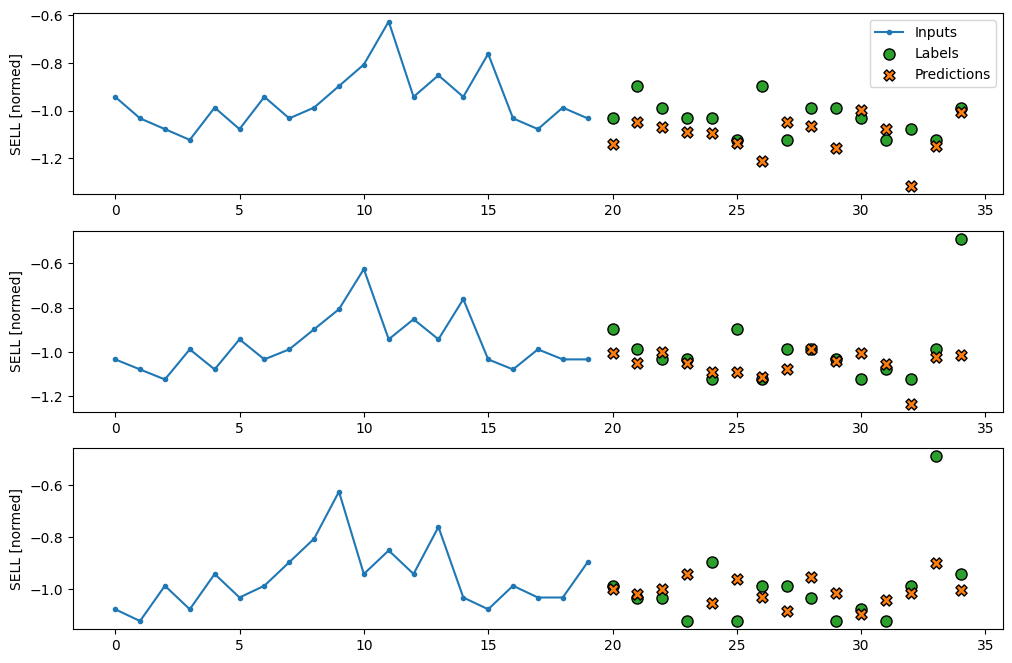

In [ ]:
mul_window.plot(multi_lstm_model)

CNN & LSTM

In [ ]:
Conv_LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64 , kernel_size = 3),
    tf.keras.layers.MaxPool1D(pool_size= 2),
    tf.keras.layers.LSTM(32 , return_sequences= False),
    tf.keras.layers.Dense(units = OUT_STEPS),
    tf.keras.layers.Reshape([OUT_STEPS , 1])
])

In [ ]:
history = compile_and_fit(Conv_LSTM_model , mul_window)

Epoch 1/20
44/44 [==============================] - 4s 28ms/step - loss: 1.1279 - mean_absolute_error: 0.8046 - val_loss: 0.4281 - val_mean_absolute_error: 0.5241
Epoch 2/20
44/44 [==============================] - 1s 27ms/step - loss: 0.9378 - mean_absolute_error: 0.7341 - val_loss: 0.3480 - val_mean_absolute_error: 0.4780
Epoch 3/20
44/44 [==============================] - 1s 28ms/step - loss: 0.7808 - mean_absolute_error: 0.6613 - val_loss: 0.3130 - val_mean_absolute_error: 0.4547
Epoch 4/20
44/44 [==============================] - 1s 26ms/step - loss: 0.6649 - mean_absolute_error: 0.6035 - val_loss: 0.3189 - val_mean_absolute_error: 0.4548
Epoch 5/20
44/44 [==============================] - 2s 36ms/step - loss: 0.5899 - mean_absolute_error: 0.5664 - val_loss: 0.3071 - val_mean_absolute_error: 0.4522
Epoch 6/20
44/44 [==============================] - 1s 26ms/step - loss: 0.5335 - mean_absolute_error: 0.5279 - val_loss: 0.3016 - val_mean_absolute_error: 0.4485
Epoch 7/20
44/44 [====

In [ ]:
performance_mul_step["Conv_LSTM_model"] = Conv_LSTM_model.evaluate(mul_window.test , return_dict = True)
val_performance_mul_step["Conv_LSTM_model"] =  Conv_LSTM_model.evaluate(mul_window.val , return_dict = True)

11/11 [==============================] - 0s 9ms/step - loss: 0.3280 - mean_absolute_error: 0.4724


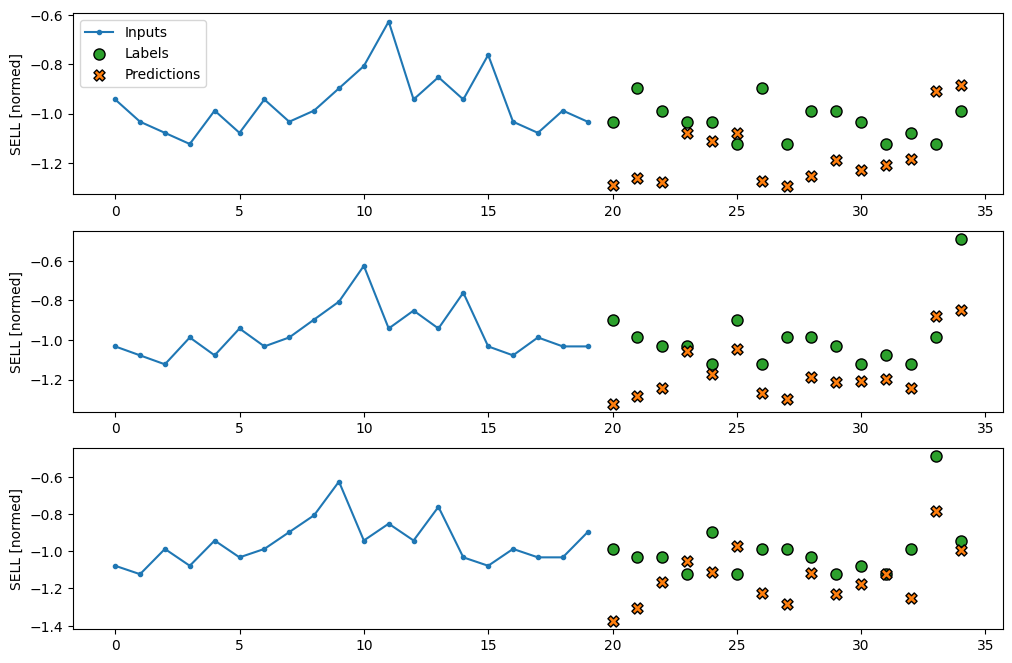

In [ ]:
mul_window.plot(Conv_LSTM_model)

Seq2Seq model

In [ ]:
class Seq2seq(tf.keras.Model):
  def __init__(self , step_inputs ,step_output, n_feature_encoder , n_feature_decoder, num_feature_predict  , layers = [60], bidirectional=False):
    super().__init__()
    self.num_layers = layers
    self.bidirectional = bidirectional
    self.step_outputs = step_output
    self.step_inputs = step_inputs
    self.n_feature_decoder = n_feature_decoder
    self.n_feature_encoder = n_feature_encoder
    self.num_feature_predict = num_feature_predict
    self.seq2seq = self.create_model()


  def create_model(self):

    n_layers = len(self.num_layers)

    ## Encoder
    encoder_inputs = Input(shape=(None,self.n_feature_encoder))
    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in self.num_layers]
    if self.bidirectional:
        encoder = Bidirectional(RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        for i in range(int(len(bi_encoder_states)/2)):
            temp = concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
            encoder_states.append(temp)
    else:
        encoder = RNN(lstm_cells, return_state=True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]

    ## Decoder
    decoder_inputs = Input(shape=(None ,self.n_feature_decoder))
    if self.bidirectional:
        decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in self.num_layers]
    else:
        decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in self.num_layers]

    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs,
                                          initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = Dense(self.num_feature_predict)
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model

  def get_filters(self):
    print("Get fillter ...")
    return self._num_layers
  def set_filters(self , value):
    if type(value) != list:
      raise TypeError("type data of filters must list")
    if len(value) < 1:
      raise ValueError(f"Error! len(layers) > 1")

    self._num_layers = value

  def call(self , inputs):
    encoder_inputs , decoder_inputs = inputs
    decoder_outputs = self.seq2seq((encoder_inputs , decoder_inputs))

    return decoder_outputs

  layers = property(get_filters , set_filters)


In [ ]:
class WindowGenerator_Seq2Seq():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs_encoder = features[:, self.input_slice, :]
    inputs_decoder = features[:, self.labels_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)
      inputs_decoder = tf.stack([inputs_decoder[:, :, self.column_indices[name]] for name in self.column_indices.keys() if name not in self.label_columns] , axis = -1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs_encoder.set_shape([None, self.input_width, None])
    inputs_decoder.set_shape([None, self.label_width, None])
    labels.set_shape([None, self.label_width, None])

    return (inputs_encoder ,inputs_decoder) , labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)


In [ ]:
INPUT_WIDTH = 20
OUT_STEPS = 15
num_feature_predict = 1
n_feature_encoder , n_feature_decoder = 94 , 93
model_Seq2Seq = Seq2seq(INPUT_WIDTH , OUT_STEPS ,n_feature_encoder , n_feature_decoder , num_feature_predict , layers = [60 , 60])

In [ ]:
mul_window_seq2seq = WindowGenerator_Seq2Seq(input_width = INPUT_WIDTH, label_width = OUT_STEPS, shift = OUT_STEPS,
               train_df =df_train, val_df = df_val, test_df= df_test , label_columns =["SELL"])

In [ ]:
mul_window_seq2seq.train.take(1).element_spec

((TensorSpec(shape=(None, 20, 94), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 15, 93), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 15, 1), dtype=tf.float32, name=None))

In [ ]:
history = compile_and_fit(model_Seq2Seq , mul_window_seq2seq)

Epoch 1/20
44/44 [==============================] - 14s 137ms/step - loss: 1.2795 - mean_absolute_error: 0.8154 - val_loss: 0.2737 - val_mean_absolute_error: 0.4387
Epoch 2/20
44/44 [==============================] - 5s 105ms/step - loss: 0.9106 - mean_absolute_error: 0.7265 - val_loss: 0.1806 - val_mean_absolute_error: 0.3374
Epoch 3/20
44/44 [==============================] - 3s 57ms/step - loss: 0.6951 - mean_absolute_error: 0.6037 - val_loss: 0.1875 - val_mean_absolute_error: 0.3421
Epoch 4/20
44/44 [==============================] - 2s 51ms/step - loss: 0.5701 - mean_absolute_error: 0.5418 - val_loss: 0.1867 - val_mean_absolute_error: 0.3398


In [ ]:
performance_mul_step["model_Seq2Seq"] = model_Seq2Seq.evaluate(mul_window_seq2seq.test , return_dict = True)
val_performance_mul_step["model_Seq2Seq"] =  model_Seq2Seq.evaluate(mul_window_seq2seq.val , return_dict = True)

11/11 [==============================] - 1s 15ms/step - loss: 0.1867 - mean_absolute_error: 0.3398


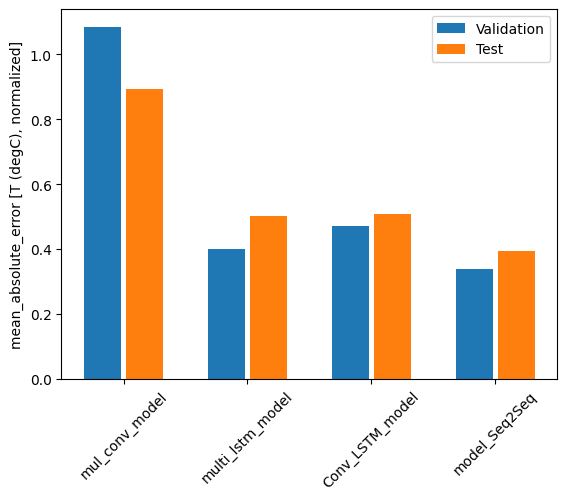

In [ ]:
compare_model(performance_mul_step , val_performance_mul_step)

# Performance comparision

In [ ]:
df_total_result_model = pd.read_csv("/content/drive/MyDrive/Capstone project m5 forecast/df_total_result_model.csv")
df_total_result_model["DATE"] = pd.to_datetime(df_total_result_model["DATE"], format = "%Y-%m-%d")
print(df_total_result_model.shape)
df_total_result_model.head(2)

(1941000, 12)


ID       DATE  SELL  ARIMA  ERROR_ARIMA  SARIMA  \
0  FOODS_1_004_CA_1_evaluation 2011-01-29   0.0    0.0          NaN     0.0   
1  FOODS_1_004_CA_1_evaluation 2011-01-30   0.0    0.0          NaN     0.0   

   ERROR_SARIMA  ETS  ERROR_ETS  ERROR_PROPHET  PROPHET  ML_LGBM  
0           NaN  0.0        NaN            NaN      0.0      0.0  
1           NaN  0.0        NaN            NaN      0.0      0.0

time: 9.5 s (started: 2024-06-24 14:42:30 +00:00)


In [ ]:
def wmape_custom(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    bias = np.sum(np.abs(y_true - y_pred))
    # bias = np.abs(np.sum(y_true) - np.sum(y_pred))
    wmape = bias / np.sum(y_true)
    return wmape

for col in ["ARIMA","ETS","PROPHET","ML_LGBM"]:
    df_eval_temp = df_total_result_model[df_total_result_model["DATE"] >= "2016-1-1"]
    print(col, wmape_custom(df_eval_temp["SELL"], df_eval_temp[col]))

ARIMA 0.7252351883132461
ETS 0.7180028699241433
PROPHET 0.6795131780417883
ML_LGBM 0.5706024880773045
time: 112 ms (started: 2024-07-27 12:02:48 +00:00)


In [ ]:
temp_plot = pd.DataFrame()
for col in ["ARIMA","ETS","PROPHET","ML_LGBM"]:
    temp_plot = pd.concat ([temp_plot,pd.DataFrame.from_dict(
        [
            accuracy_check(df_total_result_model, ground_truth = "SELL", predict_col_arr = [col])
        ]
    )])
temp_plot

model CATEGORY  Sum_actual  Mean_actual  Std_actual  Sum_predict_ARIMA  \
0  ML_LGBM  overall  22116584.0    11.394428   15.531954       1.325985e+06   
0  ML_LGBM  overall  22116584.0    11.394428   15.531954                NaN   
0  ML_LGBM  overall  22116584.0    11.394428   15.531954                NaN   
0      NaN  overall  22116584.0    11.394428   15.531954                NaN   

   Mean_predict_ARIMA  MAE_ARIMA  RMSE_ARIMA    MAPE_ARIMA  ...  \
0            0.683145  11.070601   18.959107  2.426347e+14  ...   
0                 NaN        NaN         NaN           NaN  ...   
0                 NaN        NaN         NaN           NaN  ...   
0                 NaN        NaN         NaN           NaN  ...   

   Sum_predict_PROPHET  Mean_predict_PROPHET  MAE_PROPHET  RMSE_PROPHET  \
0                  NaN                   NaN          NaN           NaN   
0                  NaN                   NaN          NaN           NaN   
0         1.442057e+06              0.742945    11.080001     18.913488   
0                  NaN                   NaN          NaN           NaN   

   MAPE_PROPHET  Sum_predict_ML_LGBM  Mean_predict_ML_LGBM  MAE_ML_LGBM  \
0           NaN                  NaN                   NaN          NaN   
0           NaN                  NaN                   NaN          NaN   
0  3.796629e+14                  NaN                   NaN          NaN   
0           NaN         1.509370e+06              0.777625    11.018874   

   RMSE_ML_LGBM  MAPE_ML_LGBM  
0           NaN           NaN  
0           NaN           NaN  
0           NaN           NaN  
0      18.85956  3.846328e+14  

[4 rows x 25 columns]

time: 1.47 s (started: 2024-06-24 14:48:41 +00:00)
